In [1]:
import pandas as pd
import glob, os
#from dataprep.eda import plot_correlation
#from dataprep.eda import plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import pandas as pd
import datacleaner
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


import random
from matplotlib import pyplot as plt
from matplotlib import colors as mpc
plt.rcParams["font.family"] = "Poppins"
from sklearn.mixture import GaussianMixture

import seaborn as sns; sns.set()
from sklearn.metrics import r2_score 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses
random_state = check_random_state(0)

from IPython.display import clear_output

%load_ext autoreload
%autoreload 
%matplotlib inline


import plotly.express as px
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
#from bioinfokit.analys import get_data, stat
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import pandas as pd
import re


To do: 
- Add google drive directory connection
- Move directory name variable to upper cell
- Process Airnote json data
- Unzip: IQAir

In [2]:
#Code to unzip files

#os.chdir('/data9/UN3400/work/kjj2125')
#!unzip IQAir_Export_raw_devices_23Oct24-08Nov24_minutely.zip
#!unzip IQAir_Export_validated_devices_07Oct24-23Oct24_hourly.zip

# Grimm Data Extraction
Iterates through every .TXT file in the directory and pulls the relevant data into different dataframes. `df_p` is the data pulled from the p line, `df_n` is the data from the n lines, `df_combined` is all the data, and `df_part` is the data used in the particulate measurement analysis

In [3]:
#This points the code towards the current directory, change this to wherever directory has the data you want
grimm_data_dir = '/data9/UN3400/work/kjj2125/GRIMM'

#### .TXT Parser

In [4]:
#Blank lists for data extracted from .txt files
p_data = []
n_data = []

# Use glob to find all .TXT files in the directory and its subdirectories
for file in glob.glob(os.path.join(grimm_data_dir, '**/*D*.TXT'), recursive=True):
    # Read each .txt file
    with open(file, 'r') as f:
        lines = f.readlines()
        # Iterate over each line to extract relevant data
        for line in lines:
            line = line.strip()  # Remove any whitespace
            if line.startswith("P"):
                # Extract values from P lines using Re code based on formatting of .txt files
                p_values = re.findall(r'\d+\.\d+|\d+', line)
                p_data.append(p_values)
            elif line.startswith("N_"):
                n_values = re.findall(r'\d+\.\d+|\d+', line)
                n_data.append(n_values)

#### Conversion to DataFrame

In [5]:
# Convert the lists into the aforementioned dataframes
df_p = pd.DataFrame(p_data, columns=[
    "Year", "Month", "Day", "Hour", "Minute", "Location", "Gravimetric Factor", "Error Code", "Battery Voltage",
    "Valve Current", "Zero Calibration", "Sensor 4", "Sensor 3", "Sensor 2", "Sensor 1", "Interval", "Col17", "Measurement #", "Col19", "Col20"
])
df_n = pd.DataFrame(n_data, columns=["TSP", "PM10", "PM2.5", "PM1", "Record Number"])
df_combined = pd.concat([df_p, df_n], axis=1)

#Extracting the particulate code
df_part = pd.DataFrame(df_combined, columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', "TSP", "PM10", "PM2.5", "PM1"])

#df_combined
#df_part

In [6]:
#checking with rows have NaN values for PM2.5
nan_rows = df_part[df_part['PM2.5'].isna()]
#nan_rows

#### Converting to `datetime`
Then using that to resample and average measurements across the hour

In [7]:
df_part = df_part.apply(pd.to_numeric, errors='coerce')

In [8]:
# Create the datetime column
df_part = df_part.apply(pd.to_numeric, errors='coerce')
df_part['datetime'] = pd.to_datetime(df_part[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str).agg('-'.join, axis=1),
                                     format='%y-%m-%d-%H-%M', errors='coerce', utc=True)
#put datetime column first
cols = ['datetime'] + [col for col in df_part.columns if col != 'datetime']
df_new = df_part[cols]
#drop old columns
df_new.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)
#df

In [9]:
# Resample the data by hour and calculate the mean for each hour
df_grimm_hour = df_new.set_index('datetime')
df_grimm_hour = df_grimm_hour.resample('H').mean()
#adding dummy column since Grimm doesn't have RH data
df_grimm_hour['RH'] = np.nan
#df_grimmm_hour

# BlueSky Sensor

In [10]:
# Function that combines all csv files in a directory into one dataframe
def csv_parser(directory):
    dataframes = []
    for file in glob.glob(os.path.join(directory, '**/*.csv'), recursive=True):
        df = pd.read_csv(file)
        dataframes.append(df)
    total_df = pd.concat(dataframes, ignore_index=True)
    return total_df

In [11]:
#Change directory to wherever the BlueSky Data is
bsky_data_dir = '/data9/UN3400/work/kjj2125/BlueSky'

In [12]:
# Concatenate all dataframes into one
df_bsky_raw = csv_parser(bsky_data_dir)
#df_bsky_raw

In [13]:
#drop rows with units
unit_indexes = df_bsky_raw[df_bsky_raw['Timestamp (Local)']=='UTC-4:00'].index
df_bsky = df_bsky_raw.drop(index=unit_indexes)

#Convert to Datetime
df_bsky['Timestamp'] = pd.to_datetime(df_bsky['Timestamp'], errors='coerce', utc = True)


#Extracting Particulate Data
df_bsky_part = pd.DataFrame(df_bsky, columns=['Timestamp', 'PM 1.0', 'PM 2.5', 'PM 4.0', 'PM 10', 'Relative Humidity' ])
df_bsky_hour = df_bsky_part.set_index('Timestamp')
df_bsky_hour = df_bsky_hour.apply(pd.to_numeric, errors='coerce')
df_bsky_hour = df_bsky_hour.resample('H').mean()
df_bsky_hour.rename(columns={'PM 1.0':'PM1', 'PM 2.5':'PM2.5', 'PM 4.0':'PM4', 'PM 10':'PM10', 'Relative Humidity':'RH'}, inplace=True)
#df_bsky_hour

# IQAir Sensor

In [14]:
#Change directory to wherever the data is
iqa_data_dir = '/data9/UN3400/work/kjj2125/IQAir'

In [15]:
# Concatenate all dataframes into one
df_iqa_raw = csv_parser(iqa_data_dir)

In [16]:
#Convert to Datetime
df_iqa_raw['Datetime_start'] = pd.to_datetime(df_iqa_raw['Datetime_start'], utc=True)

There are some weird outlier measurements on 8/9/24 that are orders of magnitude higher than the rest of measurements

In [17]:
#Extracting Particulate Data
df_iqa_part = pd.DataFrame(df_iqa_raw, columns=['Datetime_start', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'PM1 (ug/m3)', 'Humidity (%)'])
df_iqa_hour = df_iqa_part.set_index('Datetime_start')
df_iqa_hour = df_iqa_hour.apply(pd.to_numeric, errors='coerce')
df_iqa_hour = df_iqa_hour.resample('H').mean()
df_iqa_hour.rename(columns={'PM1 (ug/m3)':'PM1', 'PM2.5 (ug/m3)':'PM2.5', 'PM10 (ug/m3)':'PM10', 'Humidity (%)':'RH'}, inplace=True)

#df_iqa_hour

# Purple Air

In [18]:
#Change directory to wherever the Data is
pa_data_dir = '/data9/UN3400/work/kjj2125/PurpleAir'

df_pa_raw = csv_parser(pa_data_dir)

#Convert to Datetime
df_pa_raw['UTCDateTime'] = pd.to_datetime(df_pa_raw['UTCDateTime'], utc=True)

In [19]:
#Extracting Particulate Data
df_pa_part_raw = pd.DataFrame(df_pa_raw, columns=['UTCDateTime', 'p_0_3_um', 'p_0_5_um', 'p_1_0_um', 'p_2_5_um', 'p_5_0_um', 'p_10_0_um', 'current_humidity'])

#set datetime as index
df_pa_hour_raw = df_pa_part_raw.set_index('UTCDateTime')

#Find index of rows where the date is before 2023-01-01 & drop them
error_data_idx = df_pa_hour_raw[df_pa_hour_raw.index < '2024-01-01'].index
df_pa_hour = df_pa_hour_raw.drop(index=error_data_idx)

#Convert to numeric and resample
df_pa_hour = df_pa_hour.apply(pd.to_numeric, errors='coerce')
df_pa_hour = df_pa_hour.resample('H').mean()
df_pa_hour.rename(columns={'p_0_3_um':'PM0.3', 'p_0_5_um':'PM0.5','p_1_0_um':'PM1', 'p_2_5_um':'PM2.5', 'p_5_0_um':'PM5', 'p_10_0_um':'PM10', 'current_humidity':'RH'}, inplace=True)
#df_pa_hour

#nan_rows = df_pa_hour[df_pa_hour['p_2_5_um'].isna()]
#nan_rows

# AirGradient1

In [20]:
#Change directory to wherever the Data is
ag_data_dir = '/data9/UN3400/work/kjj2125/AirGradient1'

df_ag_raw = csv_parser(ag_data_dir)

#Convert to Datetime
df_ag_raw['UTC Date/Time'] = pd.to_datetime(df_ag_raw['UTC Date/Time'], utc=True)

#Extracting Particulate Data
df_ag_part = pd.DataFrame(df_ag_raw, columns=['UTC Date/Time', 'PM2.5 (μg/m³)', 'PM1 (μg/m³)', 'PM10 (μg/m³)', 'Humidity (%)'])
df_ag_hour = df_ag_part.set_index('UTC Date/Time')
df_ag_hour = df_ag_hour.apply(pd.to_numeric, errors='coerce')
df_ag_hour = df_ag_hour.resample('H').mean()
df_ag_hour.rename(columns={'PM1 (μg/m³)':'PM1', 'PM2.5 (μg/m³)':'PM2.5', 'PM10 (μg/m³)':'PM10', 'Humidity (%)':'RH'}, inplace=True)
#df_ag_hour

# AirGradient2

In [21]:
#Change directory to wherever the Data is
ag2_data_dir = '/data9/UN3400/work/kjj2125/AirGradient2'

df_ag2_raw = csv_parser(ag2_data_dir)

#Convert to Datetime
df_ag2_raw['UTC Date/Time'] = pd.to_datetime(df_ag2_raw['UTC Date/Time'], utc=True)

#Extracting Particulate Data
df_ag2_part = pd.DataFrame(df_ag2_raw, columns=['UTC Date/Time', 'PM2.5 (μg/m³)', 'PM1 (μg/m³)', 'PM10 (μg/m³)', 'Humidity (%)'])
df_ag2_hour = df_ag2_part.set_index('UTC Date/Time')
df_ag2_hour = df_ag2_hour.apply(pd.to_numeric, errors='coerce')
df_ag2_hour = df_ag2_hour.resample('H').mean()
df_ag2_hour.rename(columns={'PM1 (μg/m³)':'PM1', 'PM2.5 (μg/m³)':'PM2.5', 'PM10 (μg/m³)':'PM10', 'Humidity (%)':'RH'}, inplace=True)

#df_ag2_hour

# MOD AIR

In [22]:
#Change directory to wherever the Data is
mod_data_dir = '/data9/UN3400/work/kjj2125/MOD_AIR'

df_mod_raw = csv_parser(mod_data_dir)

#Convert to Datetime
df_mod_raw['timestamp'] = pd.to_datetime(df_mod_raw['timestamp'], utc=True)

#Extracting Particulate Data
df_mod_part = pd.DataFrame(df_mod_raw, columns=['timestamp', 'pm1', 'pm25', 'pm10', 'rh'])
df_mod_hour = df_mod_part.set_index('timestamp')
df_mod_hour = df_mod_hour.apply(pd.to_numeric, errors='coerce')
df_mod_hour = df_mod_hour.resample('H').mean()
df_mod_hour.rename(columns={'pm1':'PM1', 'pm25':'PM2.5', 'pm10':'PM10', 'rh':'RH'}, inplace=True)

#df_mod_hour

# MOD_PM

In [23]:
#Change directory to wherever the Data is
modpm_data_dir = '/data9/UN3400/work/kjj2125/MOD_PM'

df_modpm_raw = csv_parser(modpm_data_dir)

#Convert to Datetime
df_modpm_raw['timestamp'] = pd.to_datetime(df_modpm_raw['timestamp'], utc=True)

#Extracting Particulate Data
df_modpm_part = pd.DataFrame(df_modpm_raw, columns=['timestamp', 'pm1', 'pm25', 'pm10', 'sample_rh'])
df_modpm_hour = df_modpm_part.set_index('timestamp')
df_modpm_hour = df_modpm_hour.apply(pd.to_numeric, errors='coerce')
df_modpm_hour = df_modpm_hour.resample('H').mean()
df_modpm_hour.rename(columns={'pm1':'PM1', 'pm25':'PM2.5', 'pm10':'PM10', 'sample_rh':'RH'}, inplace=True)

#df_modpm_hour

# RAMP

In [24]:
#tweaked csv parser that ignores bad rows for problematic csv files
def csv_parser_mod(directory):
    dataframes = []
    for file in glob.glob(os.path.join(directory, '**/*.csv'), recursive=True):
        df = pd.read_csv(file, skiprows=2)
        dataframes.append(df)
    total_df = pd.concat(dataframes, ignore_index=True)
    return total_df

In [25]:
#Change directory to wherever the Data is
ramp_data_dir = '/data9/UN3400/work/kjj2125/RAMP'

df_ramp_raw = csv_parser_mod(ramp_data_dir)

#Convert to Datetime
df_ramp_raw['UTC Date Time'] = pd.to_datetime(df_ramp_raw['UTC Date Time'], utc=True)

#Extracting Particulate Data
df_ramp_part = pd.DataFrame(df_ramp_raw, columns=['UTC Date Time', 'PM_1_1_0', 'PM_1_2_5', 'PM_1_10_0', 'RH'])
df_ramp_hour = df_ramp_part.set_index('UTC Date Time')
df_ramp_hour = df_ramp_hour.apply(pd.to_numeric, errors='coerce')
df_ramp_hour = df_ramp_hour.resample('H').mean()
df_ramp_hour.rename(columns={'PM_1_1_0':'PM1', 'PM_1_2_5':'PM2.5', 'PM_1_10_0':'PM10'}, inplace=True)

#df_ramp_hour

# Sensor1 & Sensor 2

In [26]:
def csv_parser_mod2(directory):
    dataframes = []
    files = glob.glob(os.path.join(directory, '**/*.CSV'), recursive=True)
    for file in files:
        df = pd.read_csv(file)
        dataframes.append(df)
    total_df = pd.concat(dataframes, ignore_index=True)
    return total_df

In [27]:
#Change directory to wherever the Data is
sens1_data_dir = '/data9/UN3400/work/kjj2125/Sensor1'

df_sens1_raw = csv_parser_mod2(sens1_data_dir)

In [28]:
#Convert to Datetime & delete rows with 'time' instead of an actual time
df_sens1_raw['datetime'] = pd.to_datetime(df_sens1_raw['Date'] + ' ' + df_sens1_raw['Time'], errors = 'coerce', utc = True)
df_sens1_raw = df_sens1_raw.dropna(subset=['datetime'])
#df_sens1_raw

In [29]:
#Extracting Particulate Data
df_sens1_part = pd.DataFrame(df_sens1_raw, columns=['datetime', 'PM1.0', 'PM2.5', 'PM10', 'Humidity'])
df_sens1_hour = df_sens1_part.set_index('datetime')
df_sens1_hour = df_sens1_hour.apply(pd.to_numeric, errors='coerce')
df_sens1_hour = df_sens1_hour.resample('H').mean()
df_sens1_hour.rename(columns={'PM1.0':'PM1', 'Humidity':'RH'}, inplace=True)

#df_sens1_hour

In [30]:
#Change directory to wherever the Data is
sens2_data_dir = '/data9/UN3400/work/kjj2125/Sensor2'

df_sens2_raw = csv_parser_mod2(sens2_data_dir)

#Convert to Datetime
df_sens2_raw['datetime'] = pd.to_datetime(df_sens2_raw['Date'] + ' ' + df_sens2_raw['Time'], errors = 'coerce', utc=True)
df_sens2_raw = df_sens2_raw.dropna(subset=['datetime'])

#Extracting Particulate Data
df_sens2_part = pd.DataFrame(df_sens2_raw, columns=['datetime', 'PM1.0', 'PM2.5', 'PM10', 'Humidity'])
df_sens2_hour = df_sens2_part.set_index('datetime')
df_sens2_hour = df_sens2_hour.apply(pd.to_numeric, errors='coerce')
df_sens2_hour = df_sens2_hour.resample('H').mean()
df_sens2_hour.rename(columns={'PM1.0':'PM1', 'Humidity':'RH'}, inplace=True)

#df_sens2_hour

# AIRNOTE

In [31]:
#Code to unzip files

#os.chdir('/data9/UN3400/work/kjj2125/AIRNOTE/')
#!unzip AugustData.zip
#!unzip airnote_may_july.zip

In [32]:
#Change directory to wherever the Data is
airn_data_dir = '/data9/UN3400/work/kjj2125/AIRNOTE'

df_airn_raw = csv_parser(airn_data_dir)

# Convert to datetime, first see if the value is in ISO or Unix
def convert_to_datetime(value):
    if isinstance(value, int) or isinstance(value, float):  # Unix timestamp
        return pd.to_datetime(value, unit='s', errors='coerce', utc = True)  # 'unit="s"' means seconds
    elif isinstance(value, str):  # ISO 8601 string
        return pd.to_datetime(value, errors='coerce', utc = True)
    return pd.NaT  # return NaT for unrecognized formats

df_airn_raw['captured'] = df_airn_raw['captured'].apply(convert_to_datetime)

In [33]:
#Extracting Particulate Data
df_airn_part = pd.DataFrame(df_airn_raw, columns=['captured', 'pm01_0', 'pm02_5', 'pm10_0', 'humidity'])
df_airn_hour = df_airn_part.set_index('captured')
df_airn_hour = df_airn_hour.apply(pd.to_numeric, errors='coerce')
df_airn_hour = df_airn_hour.resample('H').mean()
df_airn_hour.rename(columns={'pm01_0':'PM1', 'pm02_5':'PM2.5', 'pm10_0':'PM10', 'humidity':'RH'}, inplace=True)
#df_airn_hour

# Aggregate Data

In [95]:
#List of dataframes and their respective sensors
dfs_and_sensors = [
    (df_grimm_hour, 'GRIMM'),
    (df_ag_hour, 'AirGradient1'),
    (df_ag2_hour, 'AirGradient2'),
    (df_bsky_hour, 'Bluesky'),
    (df_iqa_hour, 'IQAir'),
    (df_mod_hour, 'MOD_AIR'),
    (df_modpm_hour, 'MOD_PM'),
    (df_ramp_hour, 'RAMP'),
    (df_sens1_hour, 'Sensor1'),
    (df_sens2_hour, 'Sensor2'),
    (df_airn_hour, 'AIRNOTE'),
    (df_pa_hour, 'PurpleAir')
]

In [96]:
#set this as the maximum reasonable value for a measurement, any datapoints higher than it will be discarded
pm1_max = 500

#List for number of outliers removed for each sensor
outliers = []
df1_list = []
for df, sensor in dfs_and_sensors:
    start_len = len(df)
    end_len = len(df[df['PM1'] > pm1_max])
    outliers.append((sensor, end_len))
    df1_list.append(df.assign(Sensor=sensor)[['PM1', 'Sensor', 'RH']])


#creating full PM1 dataframe
df_pm1_out = pd.concat(df1_list)
#filter outliers
df_pm1 = df_pm1_out[df_pm1_out['PM1'] <= pm1_max]
#make sure all datetimes are utc

print("Number of measurements removed for each sensor:")
for sensor, removed in outliers:
    print(f"{sensor}: {removed}")

Number of measurements removed for each sensor:
GRIMM: 0
AirGradient1: 0
AirGradient2: 0
Bluesky: 0
IQAir: 0
MOD_AIR: 0
MOD_PM: 0
RAMP: 0
Sensor1: 2
Sensor2: 0
AIRNOTE: 0
PurpleAir: 17


In [97]:
#set this as the maximum reasonable value for a measurement, any datapoints higher than it will be discarded
pm25_max = 150

#List for number of outliers removed for each sensor
outliers = []
df25_list = []
for df, sensor in dfs_and_sensors:
    start_len = len(df)
    end_len = len(df[df['PM2.5'] > pm25_max])
    outliers.append((sensor, end_len))
    df25_list.append(df.assign(Sensor=sensor)[['PM2.5', 'Sensor', 'RH']])


#creating full PM2.5 dataframe
df_pm25_out = pd.concat(df25_list)
#filter outliers
df_pm25 = df_pm25_out[df_pm25_out['PM2.5'] <= pm25_max]


print("Number of measurements removed for each sensor:")
for sensor, removed in outliers:
    print(f"Sensor: {sensor}: {removed}")

Number of measurements removed for each sensor:
Sensor: GRIMM: 0
Sensor: AirGradient1: 0
Sensor: AirGradient2: 0
Sensor: Bluesky: 0
Sensor: IQAir: 18
Sensor: MOD_AIR: 0
Sensor: MOD_PM: 0
Sensor: RAMP: 0
Sensor: Sensor1: 2
Sensor: Sensor2: 0
Sensor: AIRNOTE: 0
Sensor: PurpleAir: 0


In [98]:
#set this as the maximum reasonable value for a measurement, any datapoints higher than it will be discarded
pm10_max = 200

#List for number of outliers removed for each sensor
outliers = []
df10_list = []
for df, sensor in dfs_and_sensors:
    start_len = len(df)
    end_len = len(df[df['PM10'] > pm10_max])
    outliers.append((sensor, end_len))
    df10_list.append(df.assign(Sensor=sensor)[['PM10', 'Sensor', 'RH']])


#creating full PM10 dataframe
df_pm10_out = pd.concat(df10_list)
#filter outliers
df_pm10 = df_pm10_out[df_pm10_out['PM10'] <= pm10_max]


print("Number of measurements removed for each sensor:")
for sensor, removed in outliers:
    print(f"{sensor}: {removed}")

Number of measurements removed for each sensor:
GRIMM: 0
AirGradient1: 0
AirGradient2: 0
Bluesky: 0
IQAir: 29
MOD_AIR: 29
MOD_PM: 45
RAMP: 0
Sensor1: 2
Sensor2: 0
AIRNOTE: 0
PurpleAir: 0


# Plots

Text(0, 0.5, 'PM1.0 Concentration')

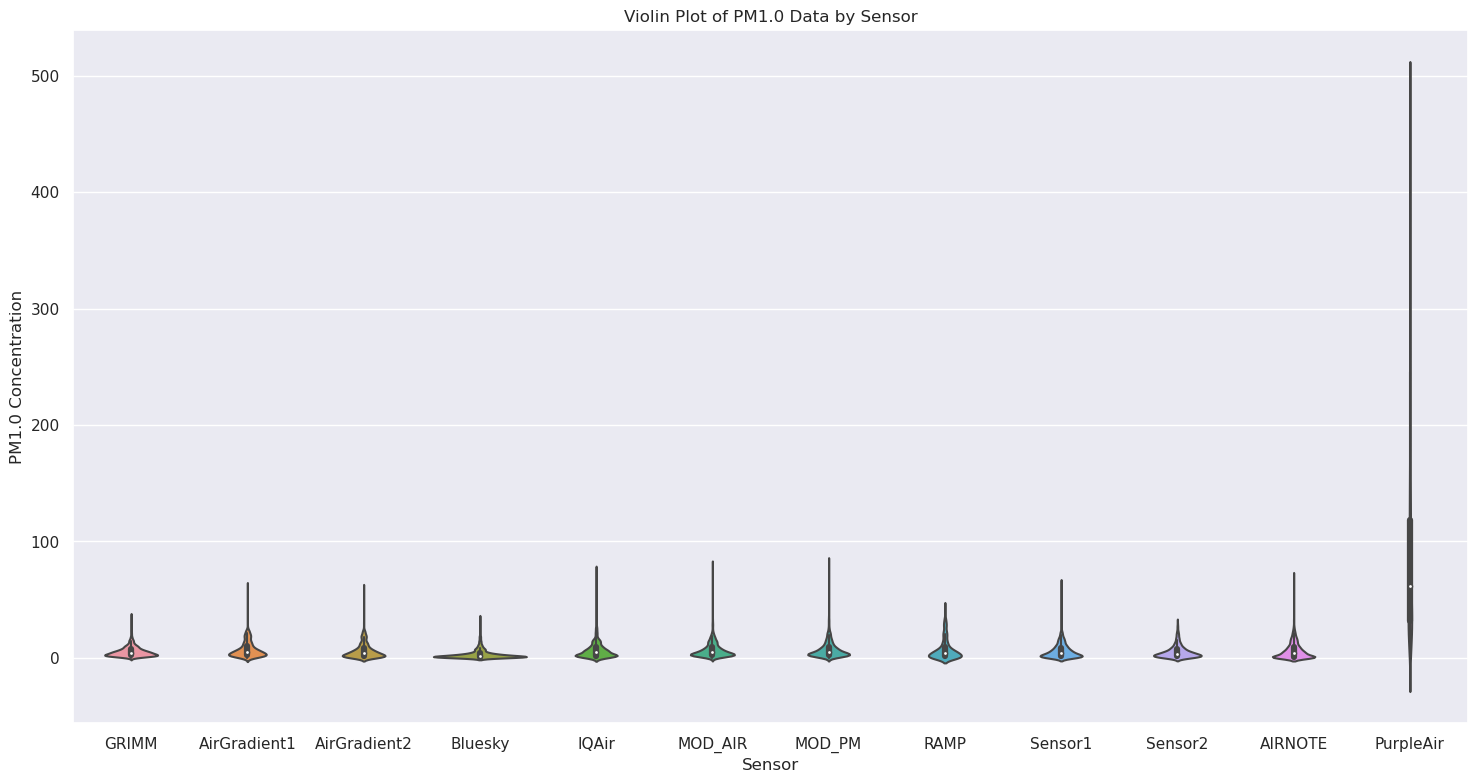

In [99]:
#creating Violin Plot
plt.figure(figsize=(18, 9))
sns.violinplot(x='Sensor', y='PM1', data=df_pm1)
plt.title('Violin Plot of PM1.0 Data by Sensor')
plt.xlabel('Sensor')
plt.ylabel('PM1.0 Concentration')
#plt.savefig('ViolinPlotPM1.png', format='png', dpi=300)

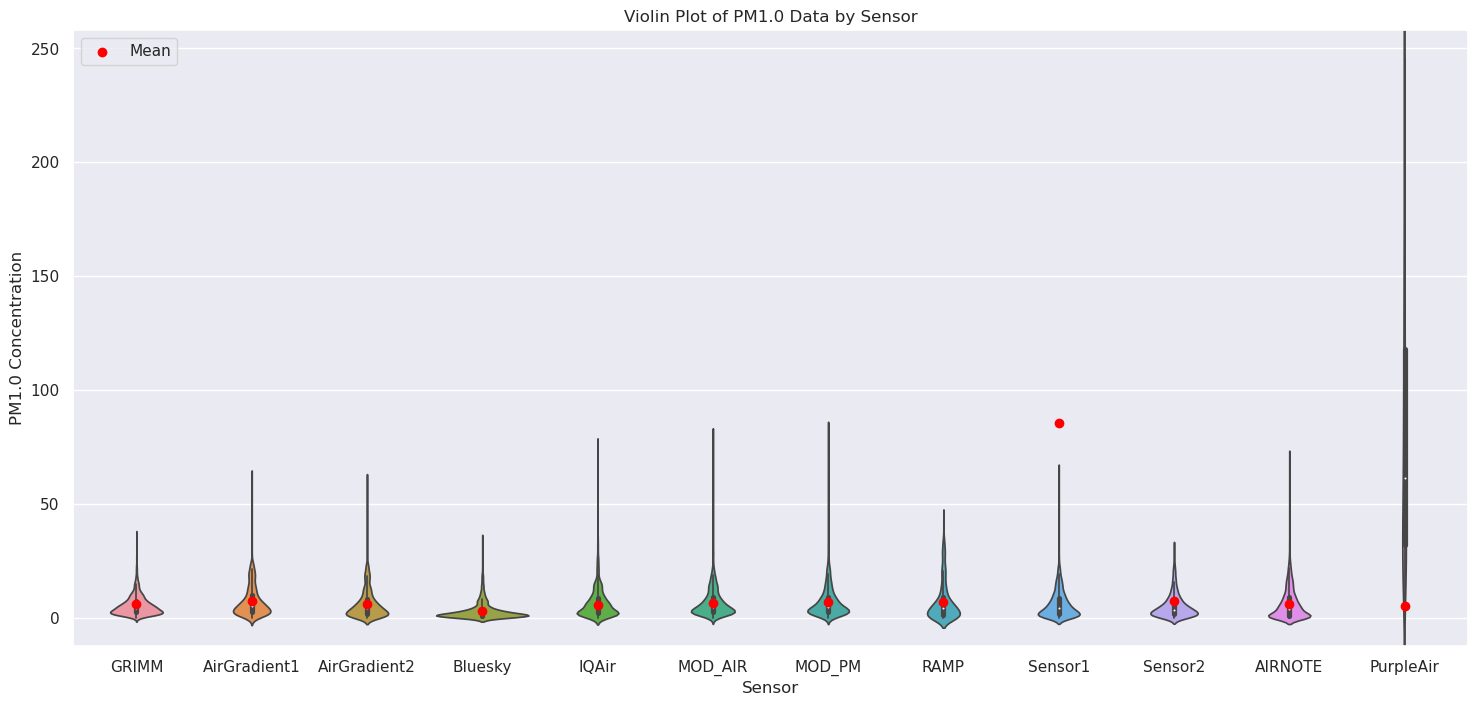

In [100]:
# Create the Violin Plot
plt.figure(figsize=(18, 8))
sns.violinplot(x='Sensor', y='PM1', data=df_pm1, inner='box', linewidth=1.25)

# add means
mean_values = df_pm1.groupby('Sensor')['PM1'].mean().reset_index()
plt.scatter(mean_values['Sensor'], mean_values['PM1'], color='red', label='Mean', zorder=5)


plt.title('Violin Plot of PM1.0 Data by Sensor')
plt.xlabel('Sensor')
plt.ylabel('PM1.0 Concentration')
plt.legend()
#plt.savefig('ViolinPlotAltPM1.png', format='png', dpi=300)
plt.show()

Text(0, 0.5, 'PM2.5 Concentration')

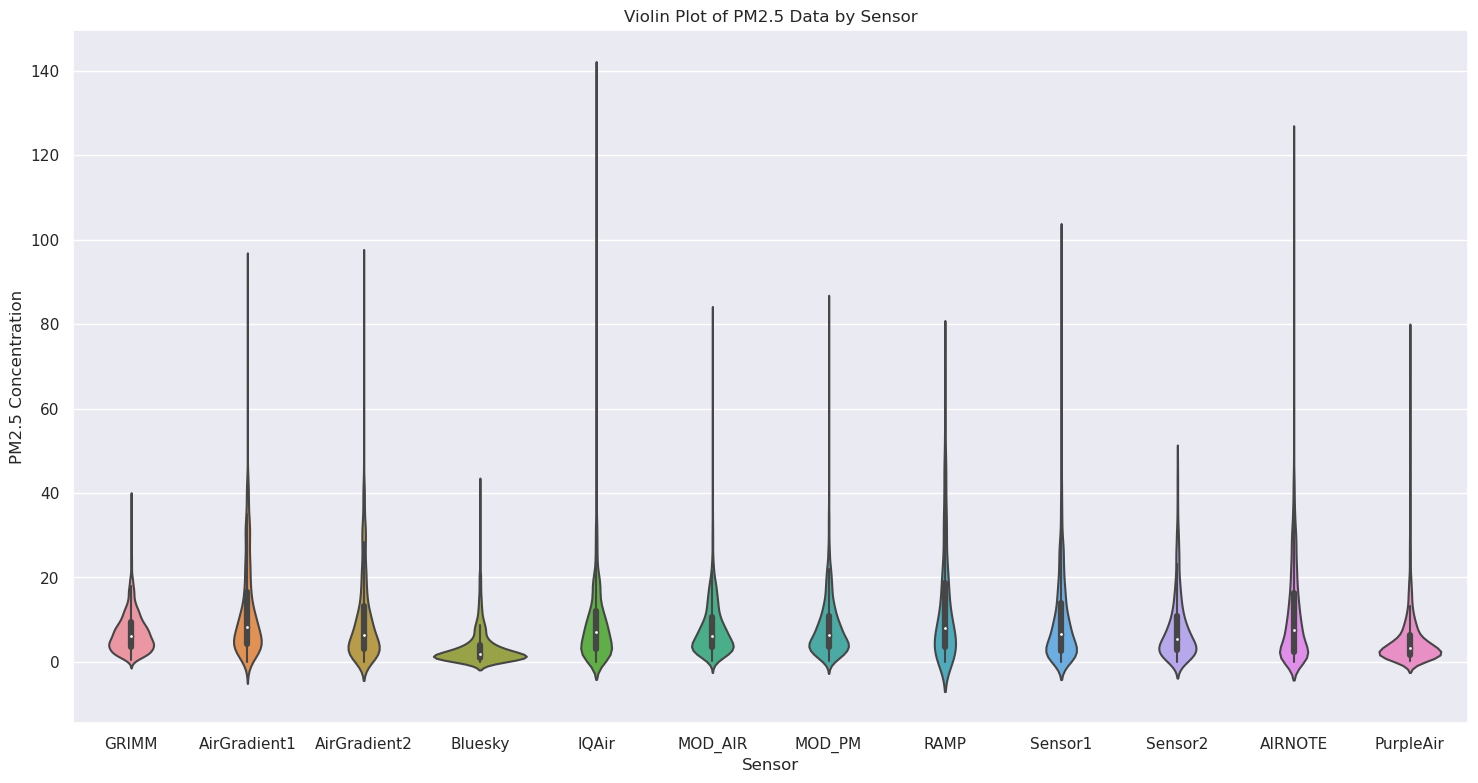

In [101]:
#creating Violin Plot
plt.figure(figsize=(18, 9))
sns.violinplot(x='Sensor', y='PM2.5', data=df_pm25)
plt.title('Violin Plot of PM2.5 Data by Sensor')
plt.xlabel('Sensor')
plt.ylabel('PM2.5 Concentration')
#plt.savefig('ViolinPlotPM2.5.png', format='png', dpi=300)

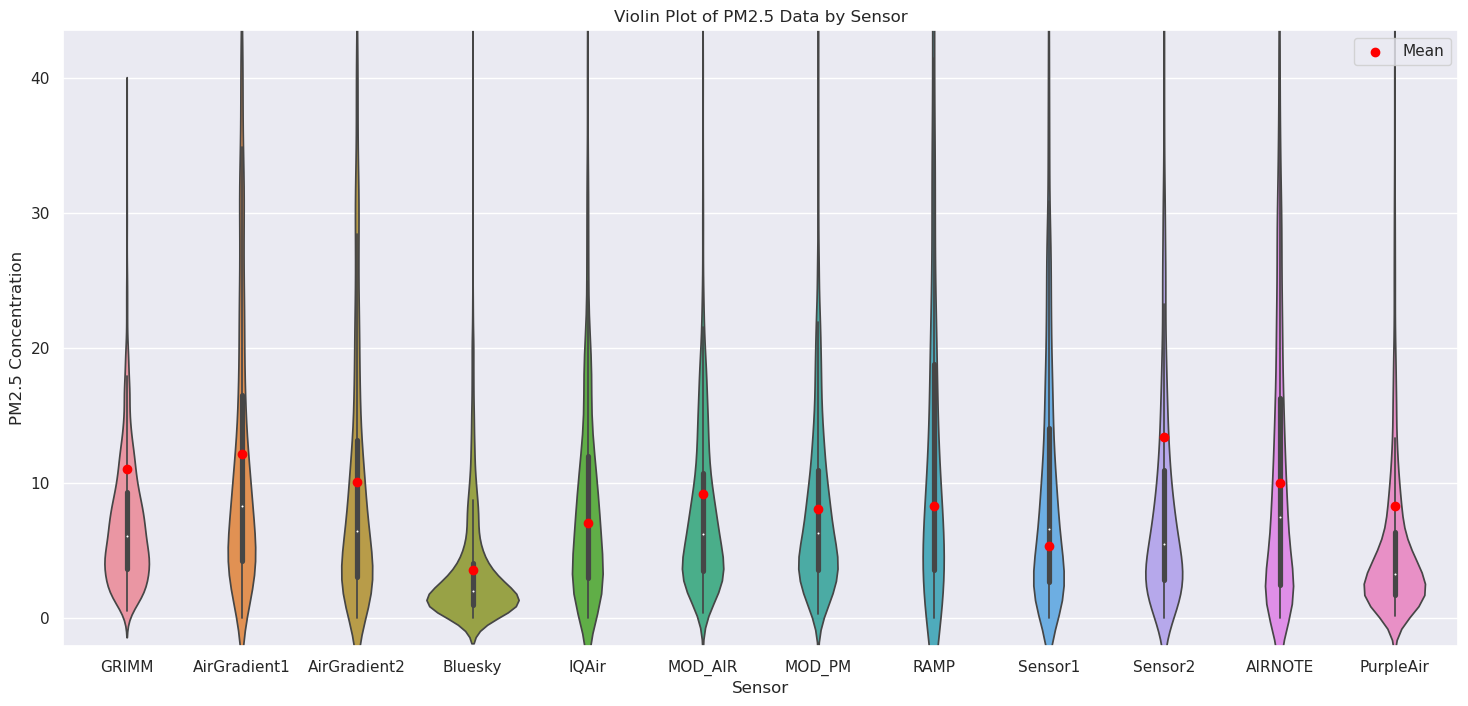

In [102]:
# Create the Violin Plot
plt.figure(figsize=(18, 8))
sns.violinplot(x='Sensor', y='PM2.5', data=df_pm25, inner='box', linewidth=1.25)

# add means
mean_values = df_pm25.groupby('Sensor')['PM2.5'].mean().reset_index()
plt.scatter(mean_values['Sensor'], mean_values['PM2.5'], color='red', label='Mean', zorder=5)


plt.title('Violin Plot of PM2.5 Data by Sensor')
plt.xlabel('Sensor')
plt.ylabel('PM2.5 Concentration')
plt.legend()
#plt.savefig('ViolinPlotAlt2.5.png', format='png', dpi=300)
plt.show()

Text(0, 0.5, 'PM10 Concentration')

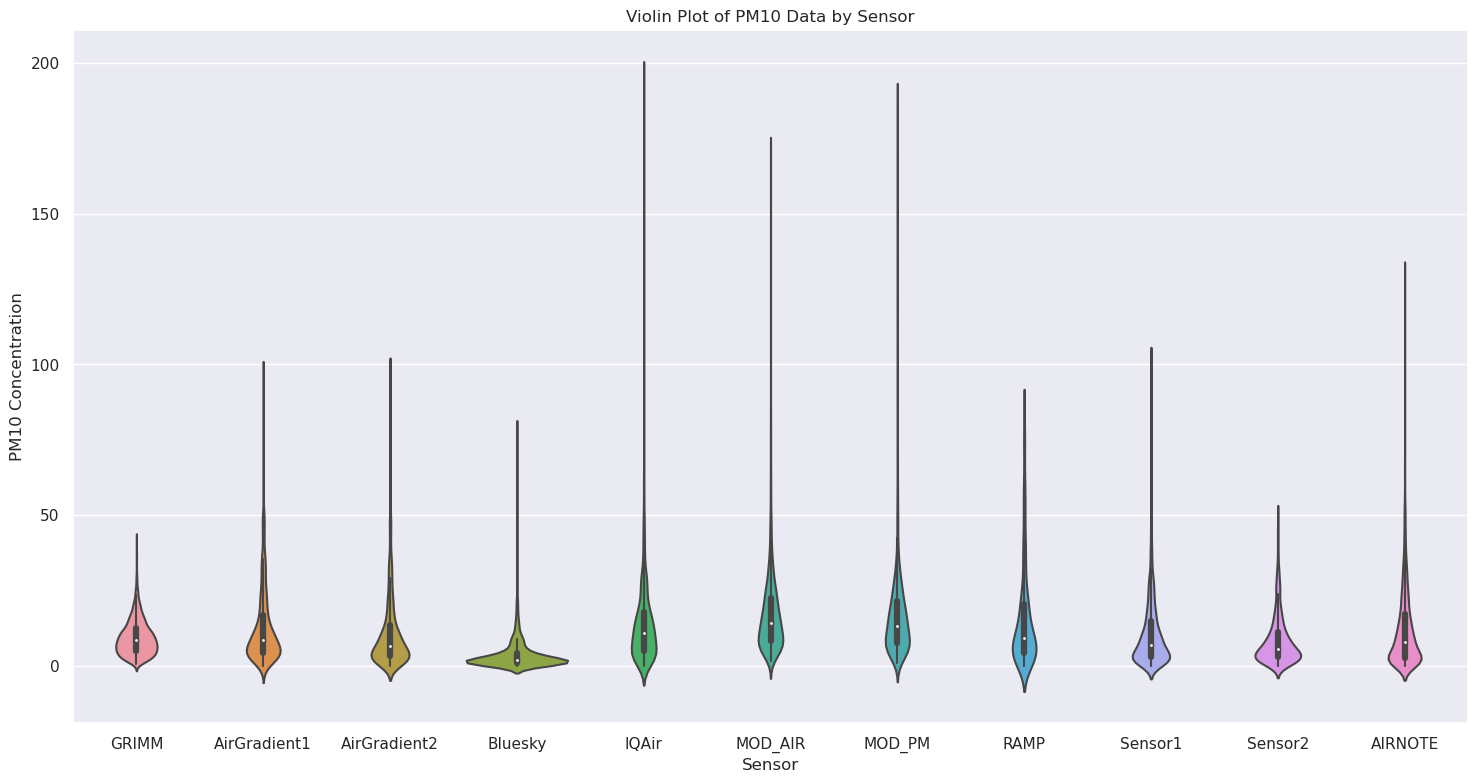

In [103]:
#creating Violin Plot
df_pm101 = df_pm10[df_pm10['Sensor'] != 'PurpleAir']
plt.figure(figsize=(18, 9))
sns.violinplot(x='Sensor', y='PM10', data=df_pm101)
plt.title('Violin Plot of PM10 Data by Sensor')
plt.xlabel('Sensor')
plt.ylabel('PM10 Concentration')
#plt.savefig('ViolinPlotPM10.png', format='png', dpi=300)

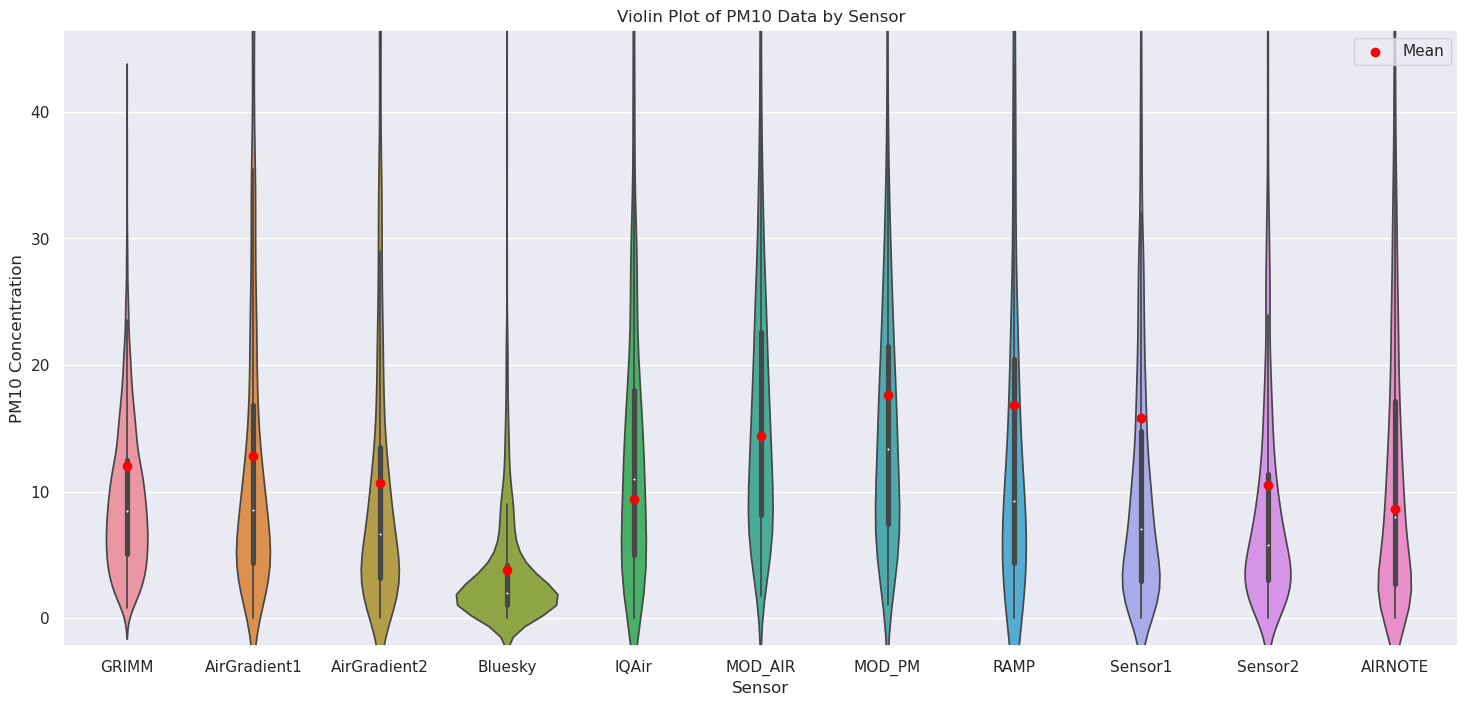

In [104]:
# Create the Violin Plot
df_pm101 = df_pm10[df_pm10['Sensor'] != 'PurpleAir']
plt.figure(figsize=(18, 8))
sns.violinplot(x='Sensor', y='PM10', data=df_pm101, inner='box', linewidth=1.25)

# add means
mean_values = df_pm101.groupby('Sensor')['PM10'].mean().reset_index()
plt.scatter(mean_values['Sensor'], mean_values['PM10'], color='red', label='Mean', zorder=5)


plt.title('Violin Plot of PM10 Data by Sensor')
plt.xlabel('Sensor')
plt.ylabel('PM10 Concentration')
plt.legend()
#plt.savefig('ViolinPlotPM10.png', format='png', dpi=300)
plt.show()

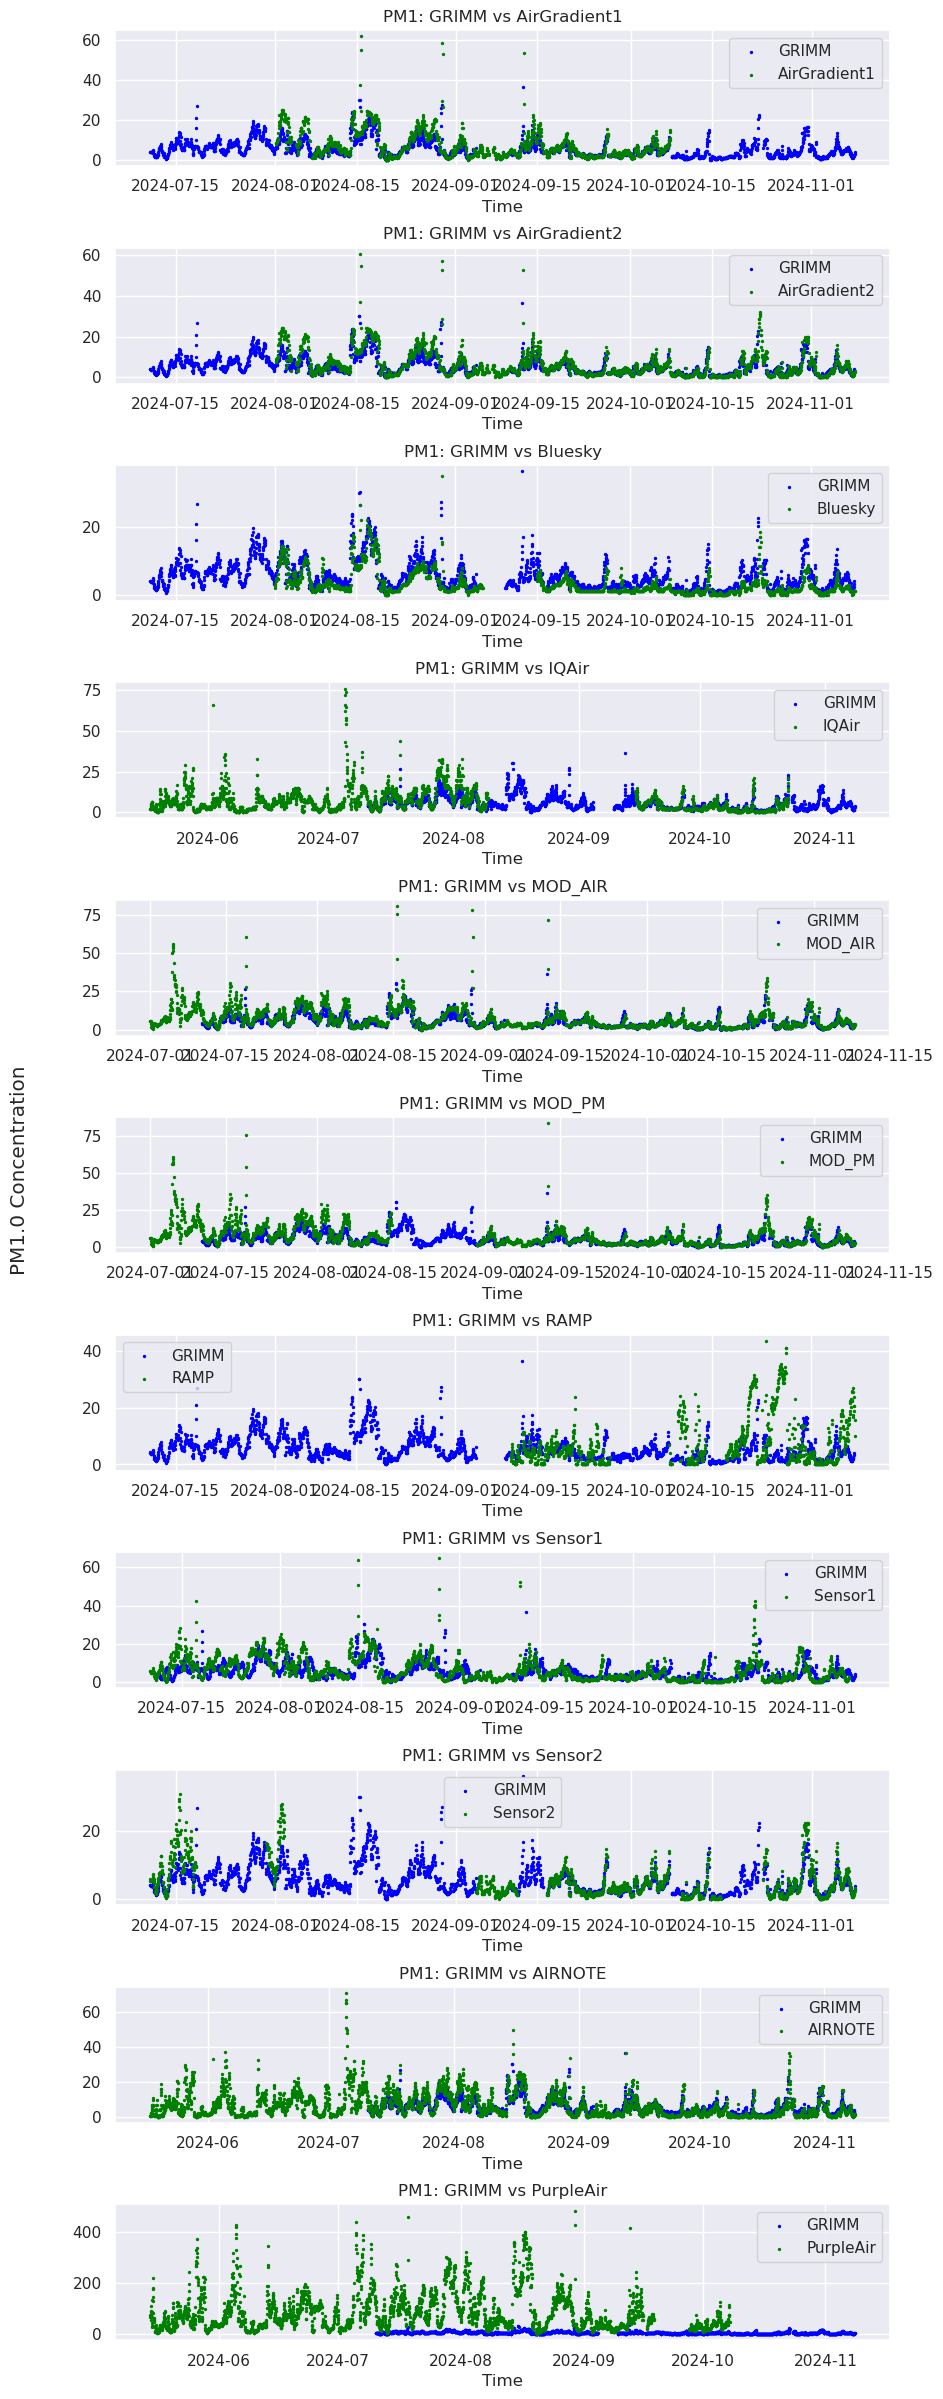

In [105]:
fig1, axes1 = plt.subplots(len(df_pm1['Sensor'].unique()) - 1, 1, figsize=(10, 30))

#pull GRIMM data
grimm_data = df_pm1[df_pm1['Sensor'] == 'GRIMM']

#Loop that plots each sensor against GRIMM
ax_index = 0
for sensor in df_pm1['Sensor'].unique():
    if sensor == 'GRIMM':
        continue
    #pull single sensor data
    sensor_data = df_pm1[df_pm1['Sensor'] == sensor]

    #plot it
    axes1[ax_index].scatter(grimm_data.index, grimm_data['PM1'], s=2, label='GRIMM', color='blue')
    axes1[ax_index].scatter(sensor_data.index, sensor_data['PM1'], s=2, label=sensor, color='green')
    axes1[ax_index].set_title(f'PM1: GRIMM vs {sensor}')
    axes1[ax_index].set_xlabel('Time')
    axes1[ax_index].legend()

    ax_index += 1

# Adjust spacing between plots
plt.subplots_adjust(hspace=.6)  
fig1.supylabel('PM1.0 Concentration')

# Show the plot
#plt.savefig('ScatterPlot_PM1.png', format='png', dpi=300)
plt.show()

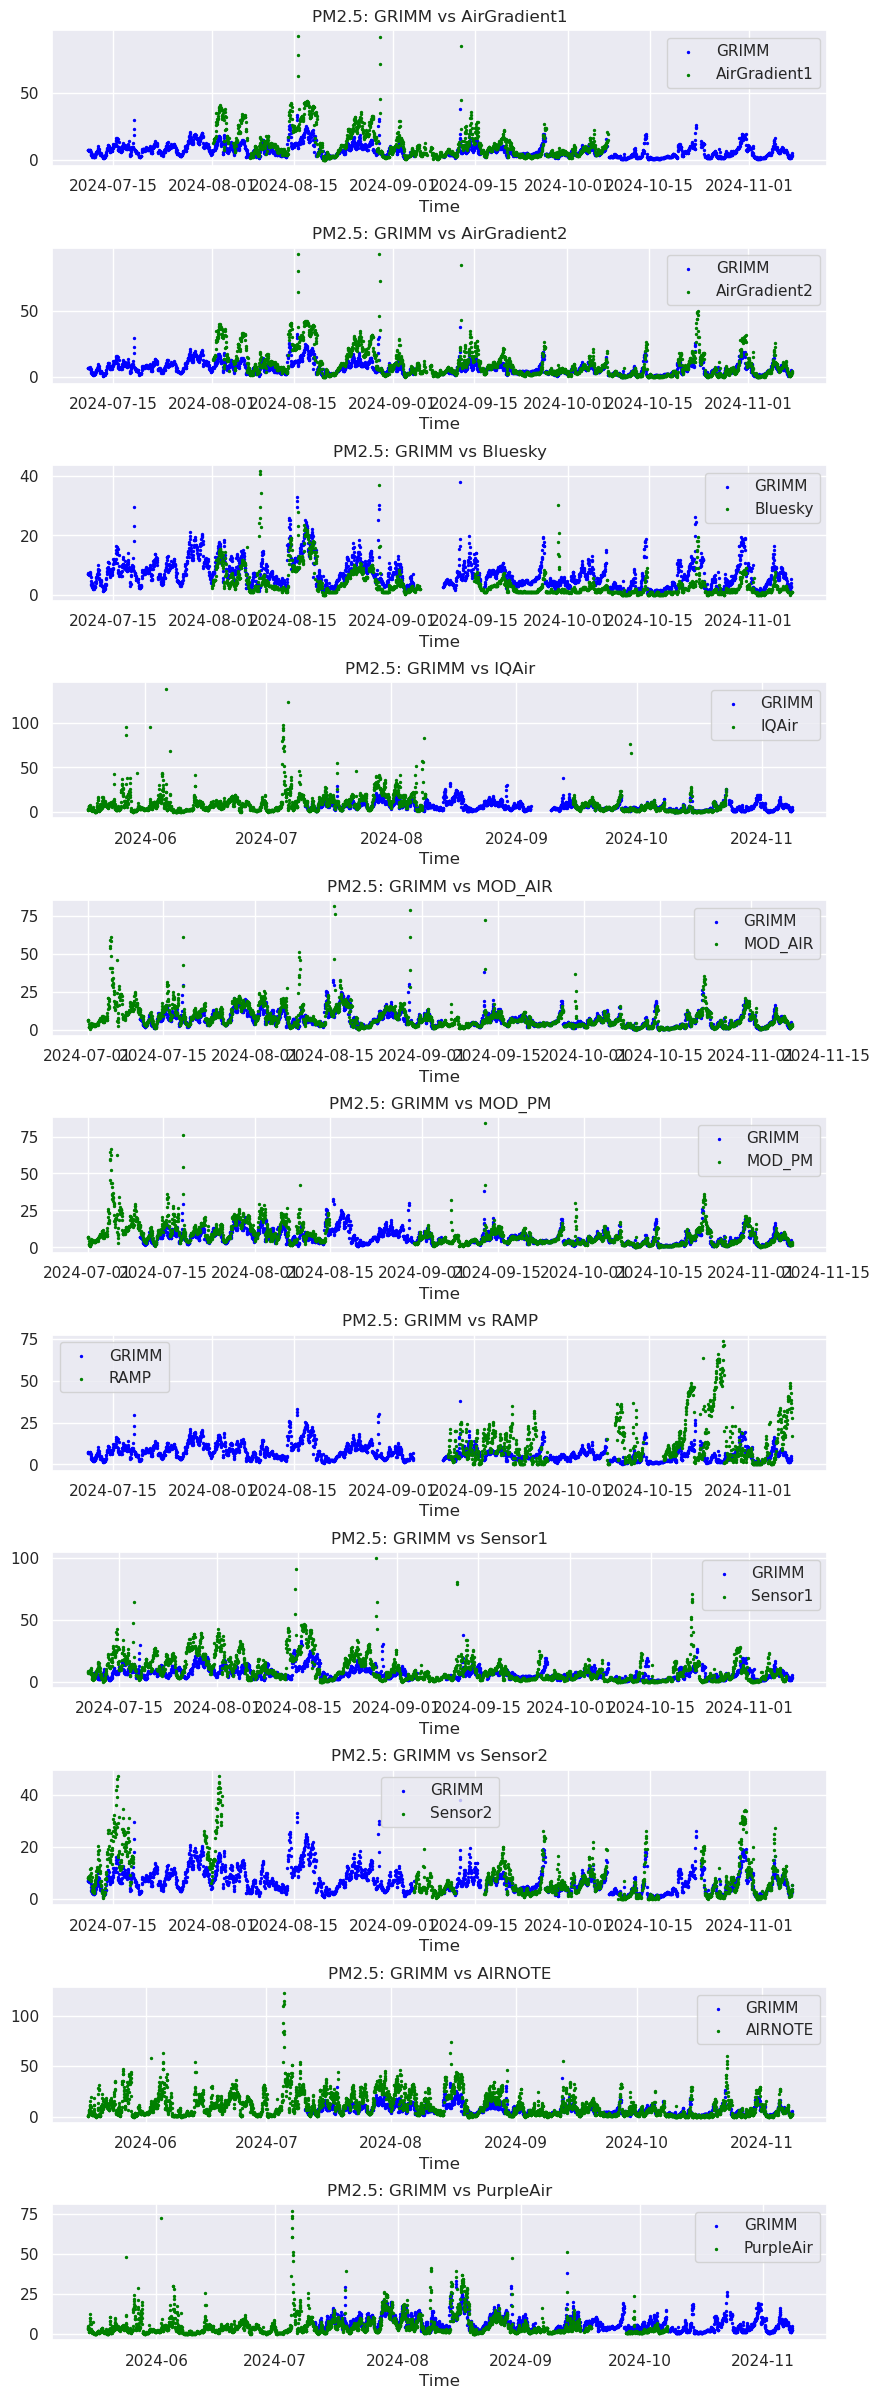

In [106]:
fig25, axes25 = plt.subplots(len(df_pm25['Sensor'].unique()) - 1, 1, figsize=(10, 30))

#pull GRIMM data
grimm_data = df_pm25[df_pm25['Sensor'] == 'GRIMM']

#Loop that plots each sensor against GRIMM
ax_index = 0
for sensor in df_pm25['Sensor'].unique():
    if sensor == 'GRIMM':
        continue  
    #pull single sensor data
    sensor_data = df_pm25[df_pm25['Sensor'] == sensor]

    #plot it
    axes25[ax_index].scatter(grimm_data.index, grimm_data['PM2.5'], s=2, label='GRIMM', color='blue')
    axes25[ax_index].scatter(sensor_data.index, sensor_data['PM2.5'], s=2, label=sensor, color='green')
    axes25[ax_index].set_title(f'PM2.5: GRIMM vs {sensor}')
    axes25[ax_index].set_xlabel('Time')
    axes25[ax_index].legend()

    ax_index += 1

# Adjust spacing between plots
plt.subplots_adjust(hspace=.6)  
fig1.supylabel('PM2.5 Concentration')

# Show the plot
plt.savefig('ScatterPlot_PM2.5.png', format='png', dpi=300)
plt.show()

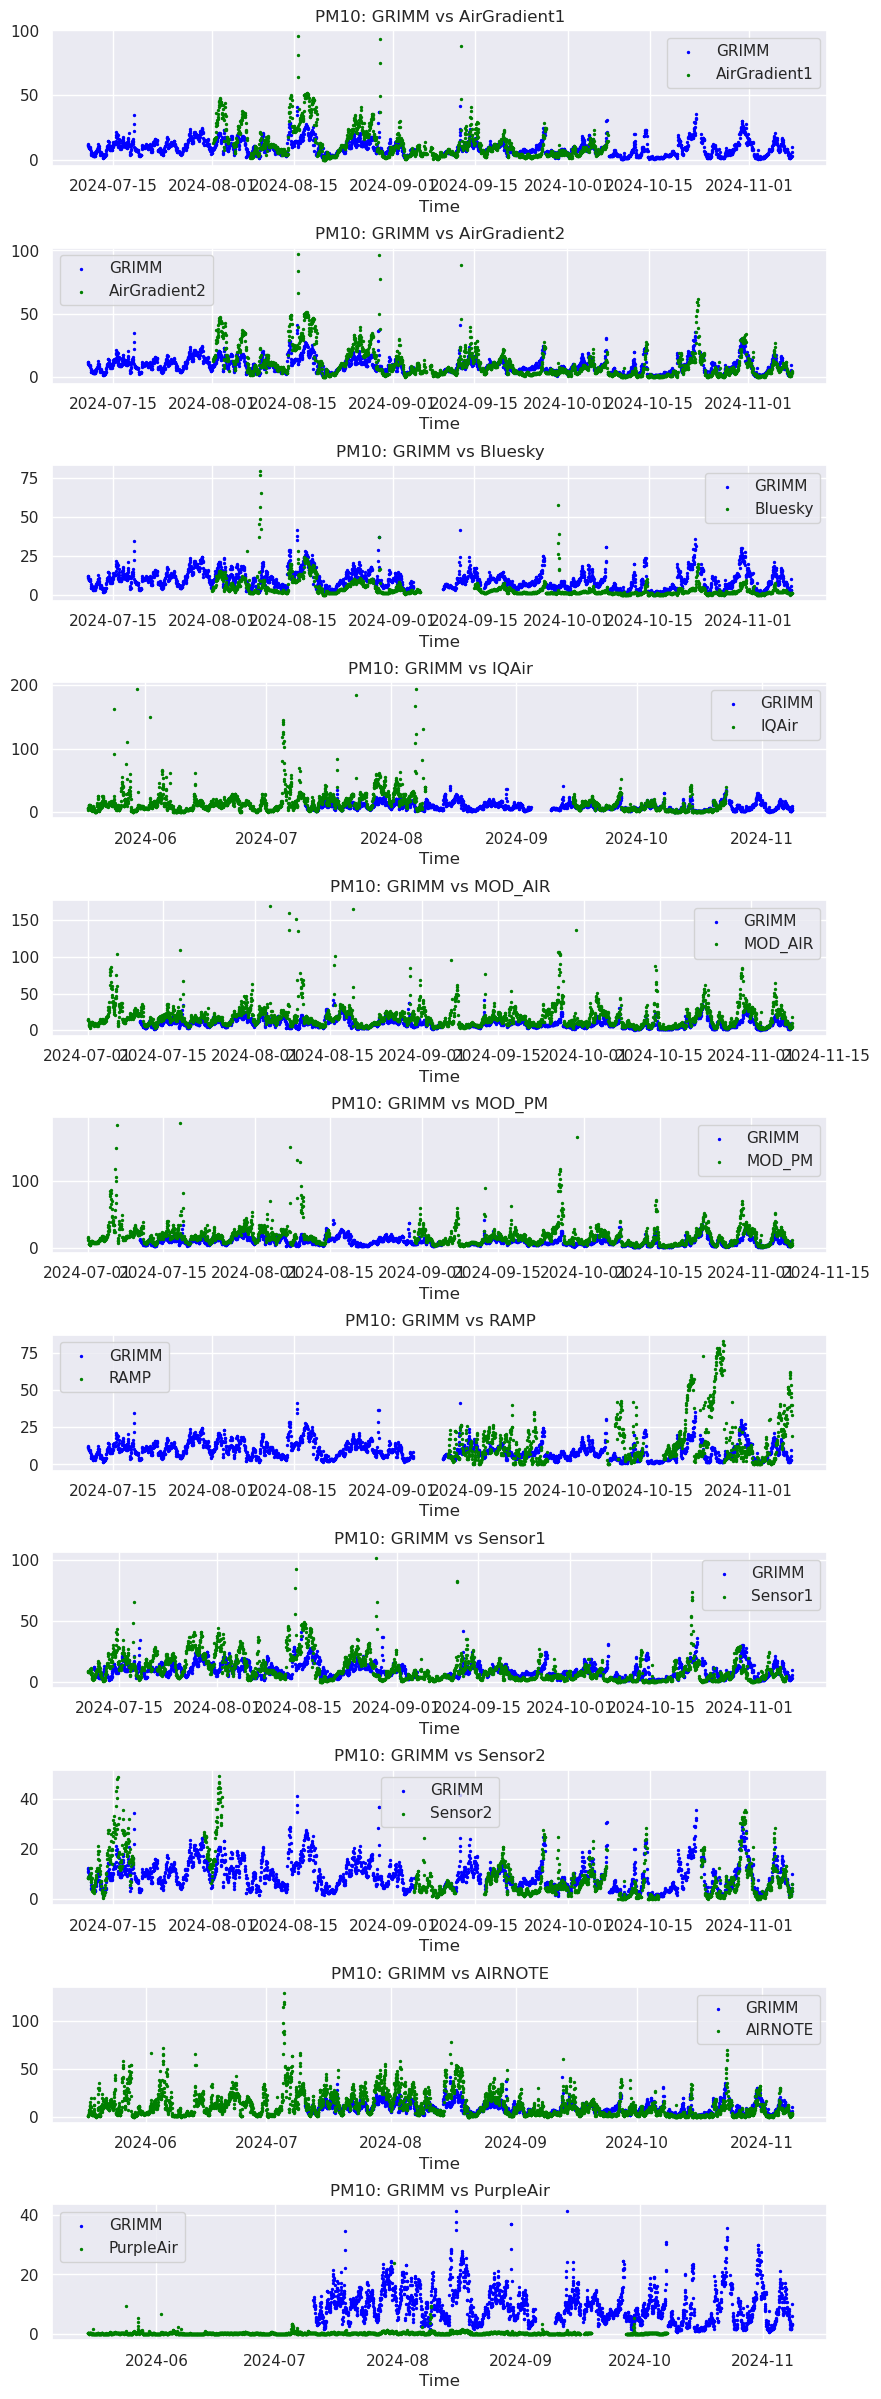

In [107]:
fig10, axes10 = plt.subplots(len(df_pm10['Sensor'].unique()) - 1, 1, figsize=(10, 30))

#pull GRIMM data
grimm_data = df_pm10[df_pm10['Sensor'] == 'GRIMM']

#Loop that plots each sensor against GRIMM
ax_index = 0
for sensor in df_pm10['Sensor'].unique():
    if sensor == 'GRIMM':
        continue  
    #pull single sensor data
    sensor_data = df_pm10[df_pm10['Sensor'] == sensor]

    #plot it
    axes10[ax_index].scatter(grimm_data.index, grimm_data['PM10'], s=2, label='GRIMM', color='blue')
    axes10[ax_index].scatter(sensor_data.index, sensor_data['PM10'], s=2, label=sensor, color='green')
    axes10[ax_index].set_title(f'PM10: GRIMM vs {sensor}')
    axes10[ax_index].set_xlabel('Time')
    axes10[ax_index].legend()

    ax_index += 1

# Adjust spacing between plots
plt.subplots_adjust(hspace=.6)  
fig1.supylabel('PM10 Concentration')

# Show the plot
plt.savefig('ScatterPlot_PM10.png', format='png', dpi=300)
plt.show()

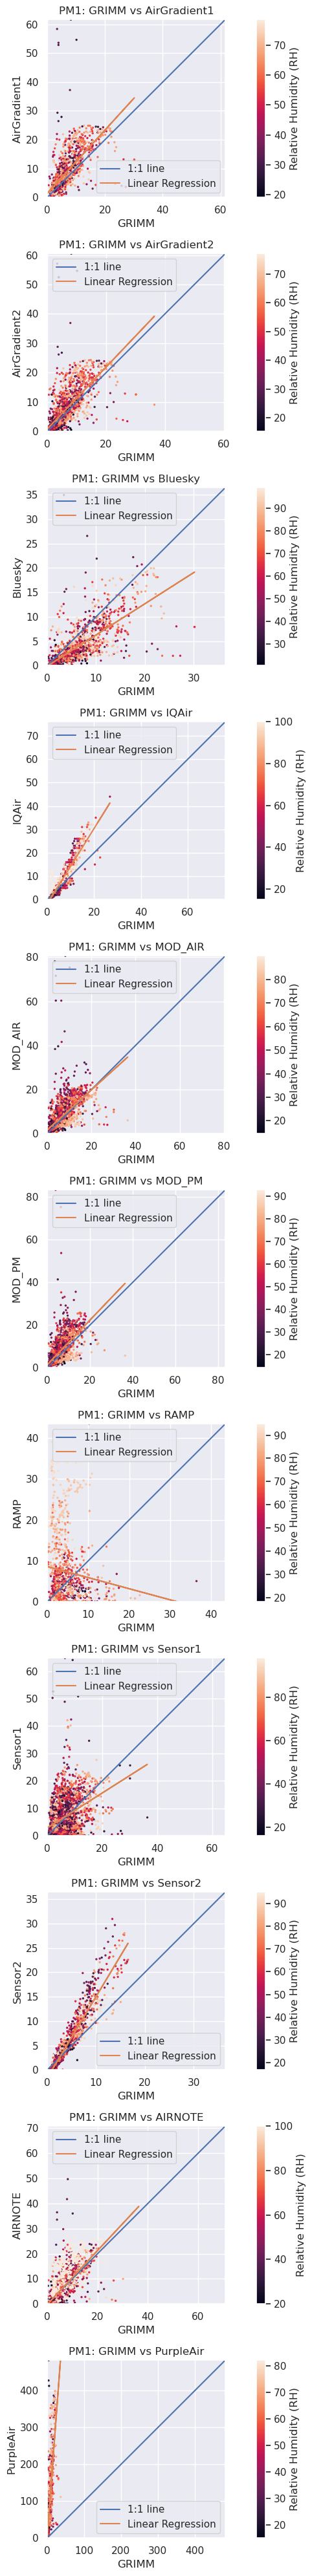

Sensor      Slope  Intercept       r^2       MNB        MAE  \
0   AirGradient1   1.097539   1.414461  0.470361       inf   2.977070   
1   AirGradient2   1.053684   0.842107  0.503747       inf   2.588374   
2        Bluesky   0.639246  -0.121817  0.544776       NaN   1.395385   
3          IQAir   1.611707  -1.826791  0.868848       NaN   1.510503   
4        MOD_AIR   0.906741   1.694217  0.386224  0.424906   2.548072   
5         MOD_PM   1.047837   1.361504  0.424096  0.417925   2.646037   
6           RAMP  -0.271284   8.611736  0.011527       inf   6.404012   
7        Sensor1   0.636048   2.876425  0.176615       inf   4.083849   
8        Sensor2   1.668699  -1.647589  0.887690       NaN   1.197248   
9        AIRNOTE   1.071714  -0.169729  0.530744       NaN   2.767852   
10     PurpleAir  13.293579   7.065230  0.545936  0.459307  34.377272   

         RMSE      CvMAE     nRMSE  
0    5.004124  37.831884  0.081174  
1    4.404824  41.149564  0.072812  
2    2.447219  44.310361  0.070054  
3    2.285750  22.907029  0.051949  
4    4.799051  37.894872  0.059637  
5    4.530422  39.515871  0.054544  
6    8.536031  86.130309  0.196547  
7    5.761824  63.647263  0.088954  
8    1.829666  21.047983  0.059164  
9    4.230862  47.926173  0.085106  
10  52.817863  36.789543  0.109624

In [108]:
fig1s, axes1s = plt.subplots(len(df_pm1['Sensor'].unique()) - 1, 1, figsize = (10,40))

#pull GRIMM data
grimm_data = df_pm1[df_pm1['Sensor'] == 'GRIMM']
grimm_max = grimm_data['PM1'].max()
reg_stats1 = pd.DataFrame(columns = ['Sensor', 'Slope', 'Intercept', 'r^2', 'MNB', 'MAE', 'RMSE', 'CvMAE', 'nRMSE'])

#Loop that plots each sensor against GRIMM
ax_index = 0
for sensor in df_pm1['Sensor'].unique():
    if sensor == 'GRIMM':
        continue  
    #pull single sensor data
    sensor_data = df_pm1[df_pm1['Sensor'] == sensor]
    sensor_max = sensor_data['PM1'].max()

    #matching data between the sensors to make scatterplot
    merged_data = pd.merge(grimm_data[['PM1']], sensor_data[['PM1', 'RH']], left_index=True, right_index=True, how='inner')

    #plot it
    scatter = axes1s[ax_index].scatter(merged_data['PM1_x'], merged_data['PM1_y'], c=merged_data['RH'], s=2)
    fig1s.colorbar(scatter, ax=axes1s[ax_index], label='Relative Humidity (RH)')
    #draw 1:1 line
    points = np.linspace(0, max(grimm_max, sensor_max), 50)
    axes1s[ax_index].plot(points,points, label = '1:1 line')
    
    #implement regression and plot it
    x = np.array(merged_data['PM1_x'].values.reshape(-1,1))
    y = merged_data['PM1_y'].values
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    axes1s[ax_index].plot(x, y_pred, label = 'Linear Regression')
    #save regression results to a dataframe
    slope = model.coef_[0]  
    intercept = model.intercept_  
    r_squared = model.score(x, y) 
    #calculate MNB, MAE, RMSE, CvMAE, and nRMSE
    mnb = np.mean((y_pred - y) / y)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(np.mean((y_pred - y) ** 2)) 
    cvmae = (mae / np.mean(y)) * 100
    range_y = np.max(y) - np.min(y)
    nrmse = rmse / range_y

    temp_df = pd.DataFrame({'Sensor': [sensor], 'Slope': [slope], 'Intercept': [intercept],'r^2': [r_squared], 'MNB':[mnb],
                           'MAE':[mae], 'RMSE':[rmse], 'CvMAE':[cvmae], 'nRMSE':[nrmse]})
    
    reg_stats1 = pd.concat([reg_stats1, temp_df], ignore_index=True)

    #Figure settings
    axes1s[ax_index].set_aspect('equal')
    axes1s[ax_index].set_xlim(0, max(grimm_max, sensor_max))
    axes1s[ax_index].set_ylim(0, max(grimm_max, sensor_max))
    axes1s[ax_index].set_title(f'PM1: GRIMM vs {sensor}')
    axes1s[ax_index].set_xlabel('GRIMM')
    axes1s[ax_index].set_ylabel(sensor)
    axes1s[ax_index].legend()


    ax_index += 1

# Adjust spacing between plots
plt.subplots_adjust(hspace=1)  
plt.tight_layout()

# Show the plot
#plt.savefig('Sensor_ScatterPlot_PM1.0.png', format='png', dpi=300)
plt.show()
reg_stats1

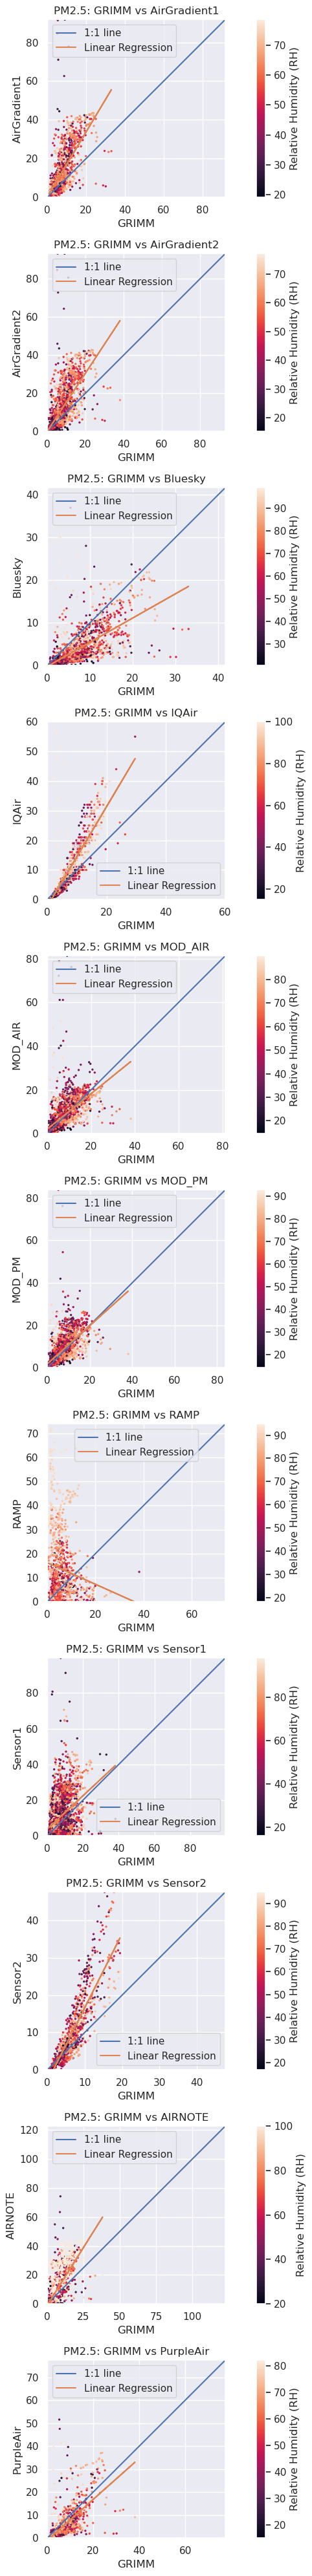

Sensor     Slope  Intercept       r^2       MNB        MAE  \
0   AirGradient1  1.673053   0.283561  0.461972  4.374369   5.267751   
1   AirGradient2  1.522453   0.096088  0.479658       inf   4.600345   
2        Bluesky  0.567492  -0.225399  0.378556       inf   1.873605   
3          IQAir  1.685250  -2.330160  0.632573       NaN   2.353051   
4        MOD_AIR  0.809998   2.060197  0.339743  0.378625   2.841177   
5         MOD_PM  0.900606   1.783838  0.381986  0.407167   2.975349   
6           RAMP -0.448859  16.241090  0.016274       inf  10.747504   
7        Sensor1  0.934089   3.780124  0.173006       inf   6.760308   
8        Sensor2  1.981332  -3.206191  0.785031       NaN   2.650366   
9        AIRNOTE  1.591595  -0.767391  0.521369       inf   4.876484   
10     PurpleAir  0.891735  -1.002480  0.410282  0.464742   2.832890   

         RMSE      CvMAE     nRMSE  
0    8.292003  41.298635  0.090368  
1    7.457100  45.039682  0.079954  
2    3.417577  52.986975  0.082022  
3    5.370745  25.665758  0.064708  
4    5.270472  36.624994  0.065101  
5    4.879888  38.450629  0.058428  
6   14.136551  78.888733  0.191474  
7    9.522382  65.159080  0.095584  
8    3.905527  30.764952  0.082140  
9    7.117768  46.766010  0.095850  
10   4.994352  46.086884  0.097064

In [113]:
fig1s, axes1s = plt.subplots(len(df_pm25['Sensor'].unique()) - 1, 1, figsize=(10, 40))

# Pull GRIMM data
grimm_data = df_pm25[df_pm25['Sensor'] == 'GRIMM']
grimm_max = grimm_data['PM2.5'].max()  # Use PM2.5 column for GRIMM data
reg_stats25 = pd.DataFrame(columns = ['Sensor', 'Slope', 'Intercept', 'r^2', 'MNB', 'MAE', 'RMSE', 'CvMAE', 'nRMSE'])

# Loop through each sensor (excluding 'GRIMM')
ax_index = 0
for sensor in df_pm25['Sensor'].unique():
    if sensor == 'GRIMM':
        continue  # Skip the 'GRIMM' sensor

    # Pull single sensor data for each sensor
    sensor_data = df_pm25[df_pm25['Sensor'] == sensor]
    sensor_max = sensor_data['PM2.5'].max()  # Use PM2.5 for the sensor

    # Merge GRIMM data with the sensor data (on index, matching rows)
    merged_data = pd.merge(grimm_data[['PM2.5']], sensor_data[['PM2.5', 'RH']], left_index=True, right_index=True, how='inner')

    # Plot the scatter plot
    scatter = axes1s[ax_index].scatter(merged_data['PM2.5_x'], merged_data['PM2.5_y'], c=merged_data['RH'], s=2)
    fig1s.colorbar(scatter, ax=axes1s[ax_index], label='Relative Humidity (RH)')
    
    # Draw 1:1 line
    points = np.linspace(0, max(grimm_max, sensor_max), 50)
    axes1s[ax_index].plot(points, points, label='1:1 line')

    # Implement linear regression
    x = np.array(merged_data['PM2.5_x'].values.reshape(-1,1))
    y = merged_data['PM2.5_y'].values
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    axes1s[ax_index].plot(x, y_pred, label = 'Linear Regression')
    #save regression results to a dataframe
    slope = model.coef_[0]  
    intercept = model.intercept_  
    r_squared = model.score(x, y) 
    #calculate MNB, MAE, RMSE, CvMAE, and nRMSE
    mnb = np.mean((y_pred - y) / y)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(np.mean((y_pred - y) ** 2)) 
    cvmae = (mae / np.mean(y)) * 100
    range_y = np.max(y) - np.min(y)
    nrmse = rmse / range_y
    #add all of the states to a dataframe and add it to the overall list
    temp_df = pd.DataFrame({'Sensor': [sensor], 'Slope': [slope], 'Intercept': [intercept],'r^2': [r_squared], 'MNB':[mnb],
                           'MAE':[mae], 'RMSE':[rmse], 'CvMAE':[cvmae], 'nRMSE':[nrmse]})
    reg_stats25 = pd.concat([reg_stats25, temp_df], ignore_index=True)

    # Figure settings
    axes1s[ax_index].set_xlim(0, max(grimm_max, sensor_max))
    axes1s[ax_index].set_ylim(0, max(grimm_max, sensor_max))
    if sensor == 'IQAir':
        axes1s[ax_index].set_xlim(0, 60)
        axes1s[ax_index].set_ylim(0, 60)
    axes1s[ax_index].set_aspect('equal')    
    axes1s[ax_index].set_title(f'PM2.5: GRIMM vs {sensor}')  
    axes1s[ax_index].set_xlabel('GRIMM')  
    axes1s[ax_index].set_ylabel(f'{sensor}')  
    axes1s[ax_index].legend()

    ax_index += 1

# Adjust spacing between plots
plt.subplots_adjust(hspace=1)  
plt.tight_layout()

# Show the plot
plt.savefig('Sensor_ScatterPlot_PM2.5.png', format='png', dpi=300)
plt.show()

# Print the regression statistics DataFrame
reg_stats25


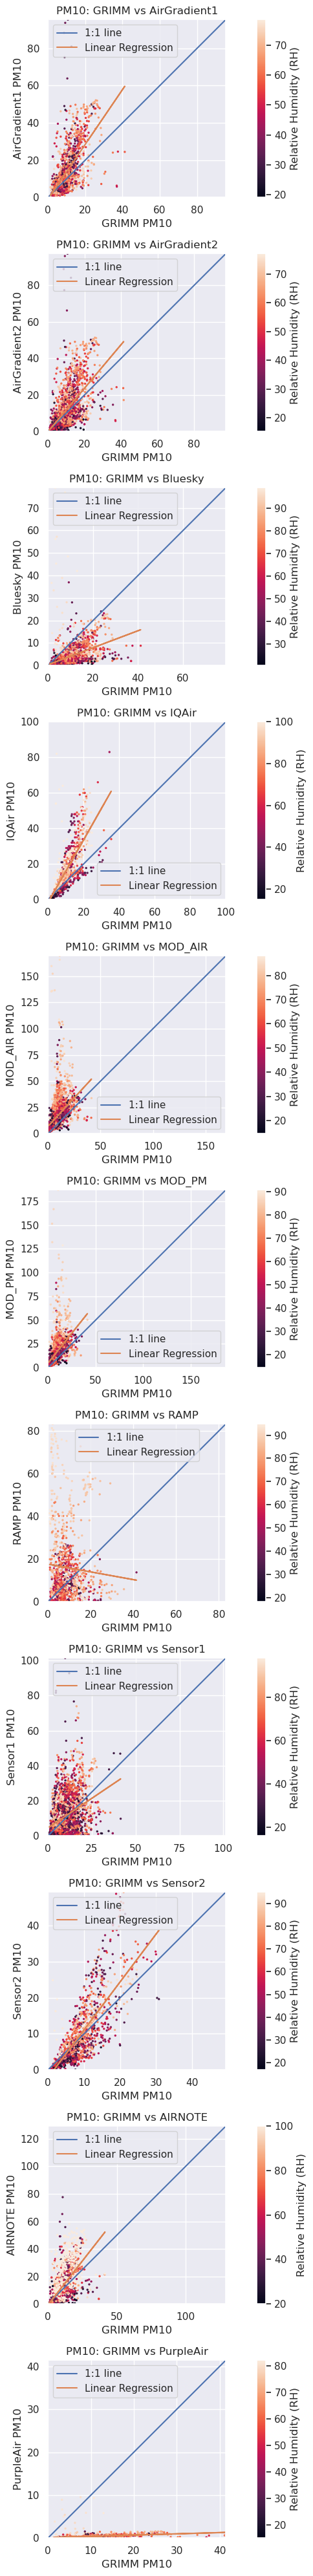

Sensor     Slope  Intercept       r^2        MNB        MAE  \
0   AirGradient1  1.470585  -0.945580  0.405942   2.958504   6.303349   
1   AirGradient2  1.190065  -0.094645  0.393524        inf   5.613113   
2        Bluesky  0.377432   0.352421  0.166123        inf   2.433380   
3          IQAir  1.762487  -1.717715  0.401587        NaN   5.040625   
4        MOD_AIR  1.087062   6.928472  0.191242   0.376296   7.253306   
5         MOD_PM  1.257414   4.752328  0.240781   0.397014   6.671738   
6           RAMP -0.181179  17.609644  0.003701        inf  12.735976   
7        Sensor1  0.674573   4.523895  0.129558  16.965488   7.304375   
8        Sensor2  1.329653  -2.189102  0.640189        NaN   3.455931   
9        AIRNOTE  1.279723  -0.734438  0.417360        inf   6.127161   
10     PurpleAir  0.029176   0.096831  0.040473   0.729411   0.216639   

         RMSE      CvMAE     nRMSE  
0    9.571735  46.906805  0.100322  
1    8.790184  52.253422  0.090313  
2    5.063311  64.221037  0.064079  
3   11.617889  34.369329  0.059886  
4   12.986146  42.102657  0.077478  
5   12.402428  41.109436  0.066726  
6   17.312239  79.325055  0.207955  
7   10.130909  66.880230  0.099952  
8    5.222354  38.509436  0.105917  
9    8.767251  53.965251  0.112949  
10   0.774050  54.506855  0.032379

In [114]:
fig1s, axes1s = plt.subplots(len(df_pm10['Sensor'].unique()) - 1, 1, figsize=(10, 40))

# Pull GRIMM data
grimm_data = df_pm10[df_pm10['Sensor'] == 'GRIMM']
grimm_max = grimm_data['PM10'].max()  # Use PM10 column for GRIMM data
reg_stats10 = pd.DataFrame(columns = ['Sensor', 'Slope', 'Intercept', 'r^2', 'MNB', 'MAE', 'RMSE', 'CvMAE', 'nRMSE'])

# Loop through each sensor (excluding 'GRIMM')
ax_index = 0
for sensor in df_pm10['Sensor'].unique():
    if sensor == 'GRIMM':
        continue  # Skip the 'GRIMM' sensor

    # Pull single sensor data for each sensor
    sensor_data = df_pm10[df_pm10['Sensor'] == sensor]
    sensor_max = sensor_data['PM10'].max()  # Use PM10 for the sensor

    # Merge GRIMM data with the sensor data (on index, matching rows)
    merged_data = pd.merge(grimm_data[['PM10']], sensor_data[['PM10', 'RH']], left_index=True, right_index=True, how='inner')

    # Plot the scatter plot
    scatter = axes1s[ax_index].scatter(merged_data['PM10_x'], merged_data['PM10_y'], c=merged_data['RH'], s=2)
    fig1s.colorbar(scatter, ax=axes1s[ax_index], label='Relative Humidity (RH)')
    
    # Draw 1:1 line
    points = np.linspace(0, max(grimm_max, sensor_max), 50)
    axes1s[ax_index].plot(points, points, label='1:1 line')

    # Implement linear regression
    x = np.array(merged_data['PM10_x'].values.reshape(-1,1))
    y = merged_data['PM10_y'].values
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    axes1s[ax_index].plot(x, y_pred, label = 'Linear Regression')
    #save regression results to a dataframe
    slope = model.coef_[0]  
    intercept = model.intercept_  
    r_squared = model.score(x, y) 
    #calculate MNB, MAE, RMSE, CvMAE, and nRMSE
    mnb = np.mean((y_pred - y) / y)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(np.mean((y_pred - y) ** 2)) 
    cvmae = (mae / np.mean(y)) * 100
    range_y = np.max(y) - np.min(y)
    nrmse = rmse / range_y
    #add all of the states to a dataframe and add it to the overall list
    temp_df = pd.DataFrame({'Sensor': [sensor], 'Slope': [slope], 'Intercept': [intercept],'r^2': [r_squared], 'MNB':[mnb],
                           'MAE':[mae], 'RMSE':[rmse], 'CvMAE':[cvmae], 'nRMSE':[nrmse]})
    reg_stats10 = pd.concat([reg_stats10, temp_df], ignore_index=True)

    # Figure settings
    axes1s[ax_index].set_aspect('equal')
    axes1s[ax_index].set_xlim(0, max(grimm_max, sensor_max))
    axes1s[ax_index].set_ylim(0, max(grimm_max, sensor_max))
    if sensor == 'IQAir':
        axes1s[ax_index].set_xlim(0, 100)
        axes1s[ax_index].set_ylim(0, 100)
    axes1s[ax_index].set_aspect('equal')  
    axes1s[ax_index].set_title(f'PM10: GRIMM vs {sensor}')  # Change title to reflect PM10
    axes1s[ax_index].set_xlabel('GRIMM PM10')  # Update xlabel to reflect PM10
    axes1s[ax_index].set_ylabel(f'{sensor} PM10')  # Update ylabel to reflect PM10
    axes1s[ax_index].legend()

    ax_index += 1

# Adjust spacing between plots
plt.subplots_adjust(hspace=1)  
plt.tight_layout()

# Show the plot
plt.savefig('Sensor_ScatterPlot_PM10.png', format='png', dpi=300)
plt.show()

# Print the regression statistics DataFrame
reg_stats10


# Queen's College Data

In [50]:
df_qcr_raw = pd.read_csv('/data9/UN3400/work/kjj2125/QCReference/export(5).csv',index_col=None)

#Fixing dataframe as it imports with a messed up multindex
df_qcr_raw = df_qcr_raw.reset_index()
df_qcr_raw = df_qcr_raw.iloc[:, :-8]
df_qcr_raw = df_qcr_raw.rename_axis('Date')
hourly_columns = [str(i) for i in range(24)] 
relevant_columns = ['Sensor', 'Date (LST)'] + hourly_columns
df_qcr_raw.columns = relevant_columns

df_melted = pd.melt(df_qcr_raw, id_vars=['Sensor', 'Date (LST)'], var_name='hour', value_name='measurement')

df_melted['Datetime'] = pd.to_datetime(df_melted['Date (LST)'], format='%m/%d/%y', utc=True) + \
                        pd.to_timedelta(df_melted['hour'].astype(int), unit='h')



#Extracting Particulate Data
df_qcr_part = pd.DataFrame(df_melted, columns=['Datetime', 'Sensor', 'measurement'])

#Filtering out measurements from sensor 1 when both were taking measurements
sensor1_timestamps = df_qcr_part[df_qcr_part['Sensor'] == 'Queens Near-roa/360810125/PM2.5-88501/1']['Datetime']
sensor2_timestamps = df_qcr_part[df_qcr_part['Sensor'] == 'Queens Near-roa/360810125/PM2.5-88502/2']['Datetime']
common_timestamps = sensor1_timestamps[sensor1_timestamps.isin(sensor2_timestamps)]
#Filter out data
df_qcr_hour = df_qcr_part[~((df_qcr_part['Sensor'] == 'Queens Near-roa/360810125/PM2.5-88502/2') & 
                            df_qcr_part['Datetime'].isin(common_timestamps))]
df_qcr_hour = df_qcr_part.set_index('Datetime')
df_qcr_hour = df_qcr_hour.apply(pd.to_numeric, errors='coerce')
df_qcr_hour.rename(columns={'measurement':'PM2.5'}, inplace=True)
df_qcr_hour.drop('Sensor', axis=1, inplace=True)

#df_qcr_hour

In [51]:
#Change directory to wherever the data is
#qc1_data_dir = '/data9/UN3400/work/kjj2125/Queens_College/Queens1.csv'
df_qc1_raw = pd.read_csv('/data9/UN3400/work/kjj2125/Queens_College/Queens1.csv')
df_qc2_raw = pd.read_csv('/data9/UN3400/work/kjj2125/Queens_College/Queens2.csv')
df_qc3_raw = pd.read_csv('/data9/UN3400/work/kjj2125/Queens_College/Queens3.csv')


#Convert to Datetime
df_qc1_raw['UTC Date/Time'] = pd.to_datetime(df_qc1_raw['UTC Date/Time'], utc=True)
#Extracting Particulate Data
df_qc1_part = pd.DataFrame(df_qc1_raw, columns=['UTC Date/Time', 'PM2.5 (μg/m³)', 'PM1 (μg/m³)', 'PM10 (μg/m³)', 'Humidity (%)'])
df_qc1_hour = df_qc1_part.set_index('UTC Date/Time')
df_qc1_hour = df_qc1_hour.apply(pd.to_numeric, errors='coerce')
df_qc1_hour = df_qc1_hour.resample('H').mean()
df_qc1_hour.rename(columns={'PM1 (μg/m³)':'PM1', 'PM2.5 (μg/m³)':'PM2.5', 'PM10 (μg/m³)':'PM10', 'Humidity (%)':'RH'}, inplace=True)

#Convert to Datetime
df_qc2_raw['UTC Date/Time'] = pd.to_datetime(df_qc1_raw['UTC Date/Time'], utc=True)
#Extracting Particulate Data
df_qc2_part = pd.DataFrame(df_qc2_raw, columns=['UTC Date/Time', 'PM2.5 (μg/m³)', 'PM1 (μg/m³)', 'PM10 (μg/m³)', 'Humidity (%)'])
df_qc2_hour = df_qc2_part.set_index('UTC Date/Time')
df_qc2_hour = df_qc2_hour.apply(pd.to_numeric, errors='coerce')
df_qc2_hour = df_qc2_hour.resample('H').mean()
df_qc2_hour.rename(columns={'PM1 (μg/m³)':'PM1', 'PM2.5 (μg/m³)':'PM2.5', 'PM10 (μg/m³)':'PM10', 'Humidity (%)':'RH'}, inplace=True)

#Convert to Datetime
df_qc3_raw['UTC Date/Time'] = pd.to_datetime(df_qc1_raw['UTC Date/Time'], utc=True)
#Extracting Particulate Data
df_qc3_part = pd.DataFrame(df_qc3_raw, columns=['UTC Date/Time', 'PM2.5 (μg/m³)', 'PM1 (μg/m³)', 'PM10 (μg/m³)', 'Humidity (%)'])
df_qc3_hour = df_qc3_part.set_index('UTC Date/Time')
df_qc3_hour = df_qc3_hour.apply(pd.to_numeric, errors='coerce')
df_qc3_hour = df_qc3_hour.resample('H').mean()
df_qc3_hour.rename(columns={'PM1 (μg/m³)':'PM1', 'PM2.5 (μg/m³)':'PM2.5', 'PM10 (μg/m³)':'PM10', 'Humidity (%)':'RH'}, inplace=True)

#df_qc3_hour

In [52]:
#List of dataframes and their respective sensors
dfs_and_sensors = [
    (df_qcr_hour, 'Reference'),
    (df_qc1_hour, 'Location 1'),
    (df_qc2_hour, 'Location 2'),
    (df_qc3_hour, 'Location 3'),

]

In [53]:
#set this as the maximum reasonable value for a measurement, any datapoints higher than it will be discarded
pm25_max = 50

df_qcr_hour['RH'] = np.nan

#List for number of outliers removed for each sensor
outliers = []
df25_list = []
for df, sensor in dfs_and_sensors:
    start_len = len(df)
    end_len = len(df[df['PM2.5'] > pm25_max])
    outliers.append((sensor, end_len))
    df25_list.append(df.assign(Sensor=sensor)[['PM2.5', 'RH', 'Sensor']])


#creating full PM2.5 dataframe
df_pm25_out = pd.concat(df25_list)
#filter outliers
df_pm25 = df_pm25_out[df_pm25_out['PM2.5'] <= pm25_max]

print(f'Outliers above {pm25_max} were removed')
print("Number of measurements removed for each sensor:")
for sensor, removed in outliers:
    print(f"{sensor}: {removed}")

Outliers above 50 were removed
Number of measurements removed for each sensor:
Reference: 6
Location 1: 9
Location 2: 15
Location 3: 340


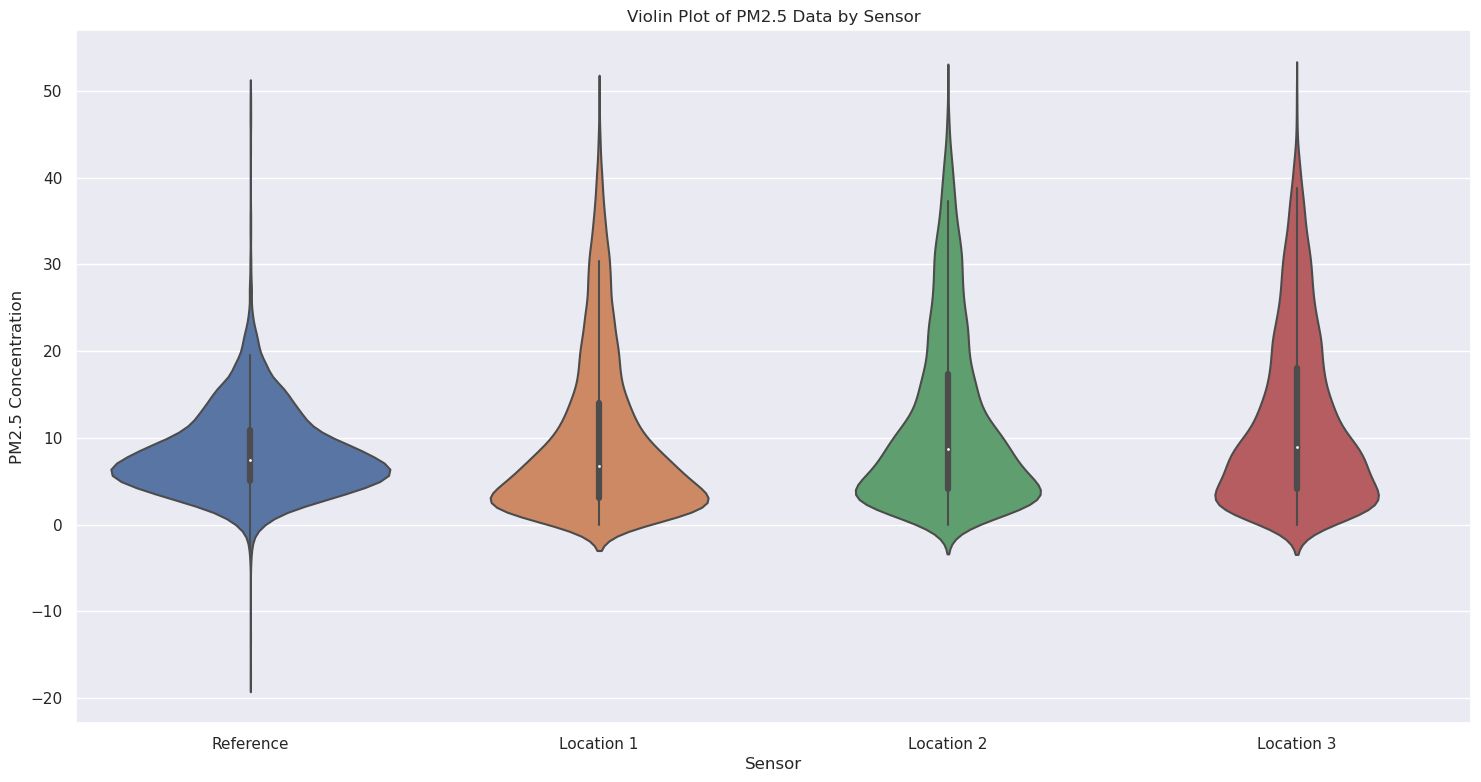

In [54]:
#creating Violin Plot
plt.figure(figsize=(18, 9))
sns.violinplot(x='Sensor', y='PM2.5', data=df_pm25)
plt.title('Violin Plot of PM2.5 Data by Sensor')
plt.xlabel('Sensor')
plt.ylabel('PM2.5 Concentration')
plt.savefig('Figures/QC_ViolinPlotPM2.5.png', format='png', dpi=300)

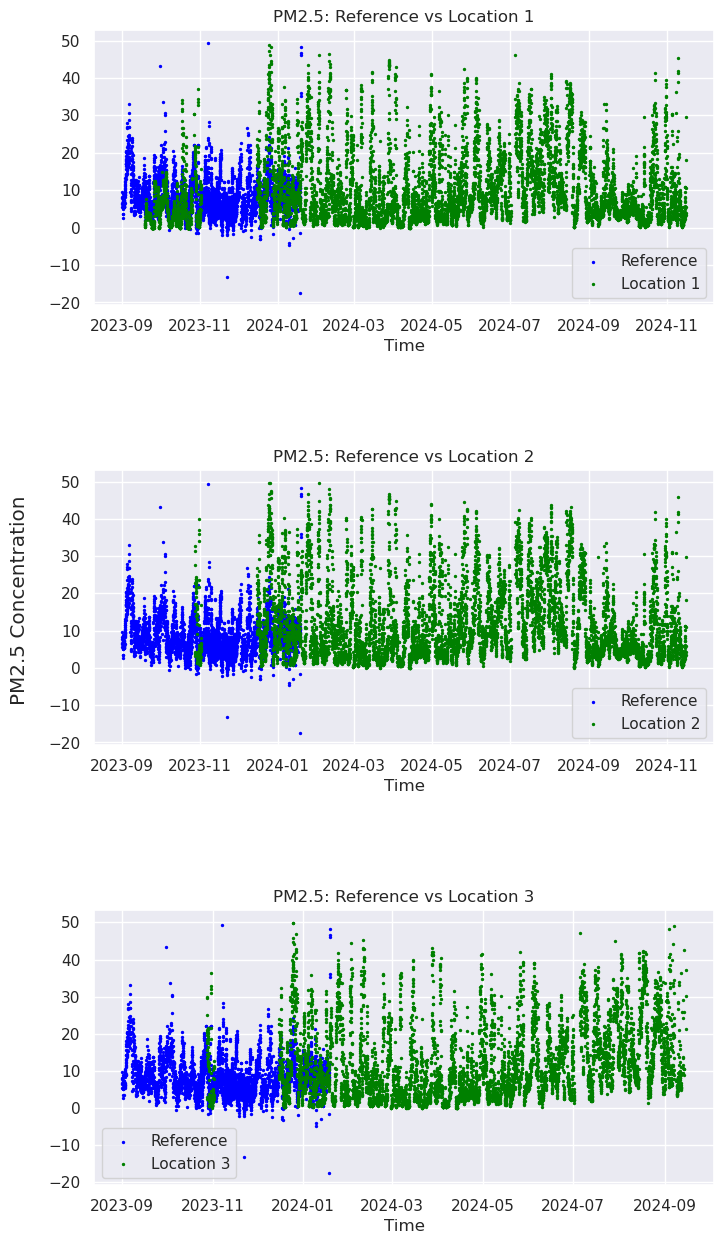

In [55]:
fig1, axes1 = plt.subplots(len(df_pm25['Sensor'].unique()) - 1, 1, figsize=(8, 15))

#pull GRIMM data
grimm_data = df_pm25[df_pm25['Sensor'] == 'Reference']

#Loop that plots each sensor against GRIMM
ax_index = 0
for sensor in df_pm25['Sensor'].unique():
    if sensor == 'Reference':
        continue
    #pull single sensor data
    sensor_data = df_pm25[df_pm25['Sensor'] == sensor]

    #plot it
    axes1[ax_index].scatter(grimm_data.index, grimm_data['PM2.5'], s=2, label='Reference', color='blue')
    axes1[ax_index].scatter(sensor_data.index, sensor_data['PM2.5'], s=2, label=sensor, color='green')
    axes1[ax_index].set_title(f'PM2.5: Reference vs {sensor}')
    axes1[ax_index].set_xlabel('Time')
    axes1[ax_index].legend()

    ax_index += 1

# Adjust spacing between plots
plt.subplots_adjust(hspace=.6)  
fig1.supylabel('PM2.5 Concentration')

# Show the plot
plt.savefig('Figures/QC_TimePlot_PM2.5.png', format='png', dpi=300)
plt.show()

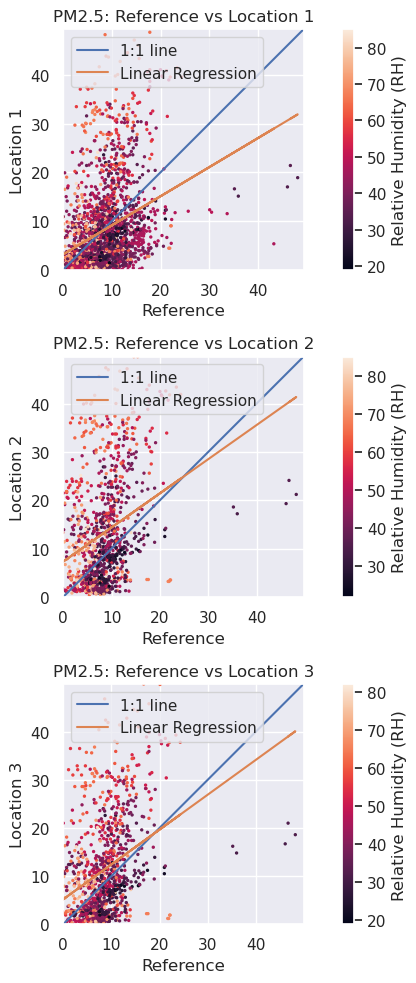

Sensor     Slope  Intercept       r^2       MNB       MAE       RMSE  \
0  Location 1  0.597102   3.132752  0.112115       inf  6.069718   8.225483   
1  Location 2  0.706193   7.311235  0.102926  1.452259  8.443433  10.399952   
2  Location 3  0.723940   5.184857  0.131509  2.119532  7.392790   9.298670   

       CvMAE     nRMSE  
0  74.578799  0.168555  
1  63.852345  0.210952  
2  65.425106  0.186720

In [56]:
fig1s, axes1s = plt.subplots(len(df_pm25['Sensor'].unique()) - 1, 1, figsize=(8, 10))

# Pull Reference data (called GRIMM from previous code)
grimm_data = df_pm25[df_pm25['Sensor'] == 'Reference']
grimm_max = grimm_data['PM2.5'].max()  # Use PM2.5 column for GRIMM data
reg_stats25 = pd.DataFrame(columns = ['Sensor', 'Slope', 'Intercept', 'r^2', 'MNB', 'MAE', 'RMSE', 'CvMAE', 'nRMSE'])

# Loop through each sensor (excluding 'GRIMM')
ax_index = 0
for sensor in df_pm25['Sensor'].unique():
    if sensor == 'Reference':
        continue  # Skip the 'GRIMM' sensor

    # Pull single sensor data for each sensor
    sensor_data = df_pm25[df_pm25['Sensor'] == sensor]
    sensor_max = sensor_data['PM2.5'].max()  # Use PM2.5 for the sensor

    # Merge GRIMM data with the sensor data (on index, matching rows)
    merged_data = pd.merge(grimm_data[['PM2.5']], sensor_data[['PM2.5', 'RH']], left_index=True, right_index=True, how='inner')

    # Plot the scatter plot
    scatter = axes1s[ax_index].scatter(merged_data['PM2.5_x'], merged_data['PM2.5_y'], c=merged_data['RH'], s=2)
    fig1s.colorbar(scatter, ax=axes1s[ax_index], label='Relative Humidity (RH)')
    
    # Draw 1:1 line
    points = np.linspace(0, max(grimm_max, sensor_max), 50)
    axes1s[ax_index].plot(points, points, label='1:1 line')

    # Implement linear regression
    x = np.array(merged_data['PM2.5_x'].values.reshape(-1,1))
    y = merged_data['PM2.5_y'].values
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    axes1s[ax_index].plot(x, y_pred, label = 'Linear Regression')
    #save regression results to a dataframe
    slope = model.coef_[0]  
    intercept = model.intercept_  
    r_squared = model.score(x, y) 
    #calculate MNB, MAE, RMSE, CvMAE, and nRMSE
    mnb = np.mean((y_pred - y) / y)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(np.mean((y_pred - y) ** 2)) 
    cvmae = (mae / np.mean(y)) * 100
    range_y = np.max(y) - np.min(y)
    nrmse = rmse / range_y
    #add all of the states to a dataframe and add it to the overall list
    temp_df = pd.DataFrame({'Sensor': [sensor], 'Slope': [slope], 'Intercept': [intercept],'r^2': [r_squared], 'MNB':[mnb],
                           'MAE':[mae], 'RMSE':[rmse], 'CvMAE':[cvmae], 'nRMSE':[nrmse]})
    reg_stats25 = pd.concat([reg_stats25, temp_df], ignore_index=True)

    # Figure settings
    axes1s[ax_index].set_aspect('equal')
    axes1s[ax_index].set_xlim(0, max(grimm_max, sensor_max))
    axes1s[ax_index].set_ylim(0, max(grimm_max, sensor_max))
    axes1s[ax_index].set_title(f'PM2.5: Reference vs {sensor}')  
    axes1s[ax_index].set_xlabel('Reference')  
    axes1s[ax_index].set_ylabel(f'{sensor}')  
    axes1s[ax_index].legend()

    ax_index += 1

# Adjust spacing between plots
plt.subplots_adjust(hspace=1)  
plt.tight_layout()

# Show the plot
plt.savefig('Figures/QC_ScatterPlot_PM2.5.png', format='png', dpi=300)
plt.show()

# Print the regression statistics DataFrame
reg_stats25
